# Contexte

Le travail suivant a été réalisé par :
- ADAM Gregory (SDIA TPS)
- CHAILLOUX Matthieu (SDIA TPS)

et ce dans le cadre du cours "Science des données appliquées" du M2 SDIA / SDSC

# Import modules et données

In [213]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [186]:
taxon_df = pd.read_csv("données/taxon.csv")
taxon_denombre_df = pd.read_csv("données/taxon_denombre.csv")
liste_df = pd.read_csv("données/liste_faunistique_floristique.csv")
stations_df = pd.read_csv("données/station.csv")
physicochimie_df = pd.read_csv("données/physicochimie.csv")
alteration_df = pd.read_csv("données/classe_alteration_seq_eau.csv")

# Problèmatique retenue

Après lecture de la description des données et une première visualisation des différents datasets, nous avons décidé de nous intéresser à la question suivante : "Est-il possible d'établir un lien entre l'évolution de paramètres physico-chimiques et celle du nombre d'individus, pour un taxon et une zone géographique donnée ?"

Les données sont réparties en de multiples tableaux et les analyser sans but précis est inutile. On dispose de données relatives aux espèces observées en une zone géographique (une station), de mesures sur ces espèces, d'une hiérarchie sur ces espèces, de relevés de multiples paramètres physico-chimiques de l'eau et une liste de classes d'altérations, correspondant à des combinaisons de valeurs pour ces paramètres.

Pour exposer le raisonnement derrière le choix de notre problématique, commençons par récupérer la liste complète des paramètres mesurés sur les membres d'un taxon (un groupement d'espèce).

Tout d'abord, un extrait de la table taxon_denombre :

In [187]:
taxon_denombre_df.head(10)

liste_ff_id  taxon_id  valeur                                critere_taxon  \
0      3551360       322     1.0                     Nombre exact d'individus   
1      3551268       837     8.0                     Nombre exact d'individus   
2      3663043      2080    60.0      Longueur Minimale totale exprimée en mm   
3      3551258       906   120.0                     Nombre exact d'individus   
4      3671035      2012     1.0                Poids individuel exprimé en g   
5      3551262       221     2.0                     Nombre exact d'individus   
6      3551413       383     2.0                     Nombre exact d'individus   
7      3671035      2080     1.0                     Nombre exact d'individus   
8      3551265       319     1.0                     Nombre exact d'individus   
9      3671035      2080    32.0  Longueur Individuelle totale exprimée en mm   

   critere_taxon_id  
0                 1  
1                 1  
2                 2  
3                 1  
4                 3  
5                 1  
6                 1  
7                 1  
8                 1  
9                 4

In [188]:
taxon_denombre_df[["critere_taxon", "critere_taxon_id"]]\
    .sort_values("critere_taxon")\
    .set_index("critere_taxon_id")\
    .drop_duplicates()

critere_taxon
critere_taxon_id                                                   
7                                            Abondance Relative (%)
4                       Longueur Individuelle totale exprimée en mm
11                Longueur Individuelle à la fourche exprimée en mm
6                           Longueur Maximale totale exprimée en mm
15                    Longueur Maximale à la fourche exprimée en mm
2                           Longueur Minimale totale exprimée en mm
13                    Longueur Minimale à la fourche exprimée en mm
1                                          Nombre exact d'individus
3                                     Poids individuel exprimé en g
12                Poids individuel exprimé en g dont la méthode ...
10                Poids individuel exprimé en g partir d'un autr...
8                 Poids individuel exprimé en g à partir d'une e...
17                Poids individuel exprimé en g à partir d'une e...
5                 Poids total de l'ensemble des individus appart...
14                Poids total de l'ensemble des individus appart...
16                Poids total de l'ensemble des individus appart...
9                 Poids total de l'ensemble des individus appart...
18                Poids total de l'ensemble des individus appart...

18 paramètres uniques sont présents:
- 6 portés sur des mesures de longueurs, d'un individu ou d'un ensemble
- 10 portés sur le poids d'un individu ou d'un ensemble
- L'abondance relative. Nous n'avons pas saisi clairement à quoi se référait ce paramètre. Nous avons trouvé quelques ressources sur le site du SANDRE ([liste de paramètres en hydrobiologie](https://mdm.sandre.eaufrance.fr/node/413859), [Abondance relative comme définie par l'IBMA](https://mdm.sandre.eaufrance.fr/node/413859)) mais sa signification reste floue. Peut-être est-ce la proportion observée comparée à une proportion standard attendue pour ce taxon dans un type de milieu donnée, ou une proportion par rapport à l'ensemble des taxons prélevés.
- Le nombre exact d'individus

Nous ne nous sommes intéressés qu'à ce dernier critère. Les mesures individuelles ne nous semblent que peu pertinentes d'un point de vue statistique. Le poids et la taille dependent, entre autres, du développement, croissance, survie et capacité à se nourrir correctement des individus, critères qui influent directement sur le nombre d'individus dans une population. Ce critère semble donc pertinent pour une première analyse.

Enfin, on peut constater des irrégularités dans les mesures de poids et de longueurs (poids nuls ou négatifs pour respecter les totaux associés, poids min > poids max...). Il est clair qu'il est plus difficile d'avoir une erreur si grossière sur un compte d'individus.
Enfin, il existe en hydrobiologie des critères se concentrant sur le nombre d'individus (IBGN, par exemple). Si ceux-ci ont leur limites, il est évident que le nombre d'individus reste une donnée intéressante et nous semble être adapté à une analyse par des non-experts du domaine.

Nous concentrer sur un unique paramètre nous permet aussi de passer plus de temps sur le travail de réflexion et d'analyse.

# Préparation des données

Pour l'ensemble des relevés, on ne s'intéresse qu'à l'année comme date.

On s'intéresse à l'évolution du nombre d'individus, on vérifie qu'un unique code de critère y est associé.

In [189]:
critere_nombre_individus = taxon_denombre_df[taxon_denombre_df["critere_taxon"] == "Nombre exact d'individus"]\
    ["critere_taxon_id"]\
    .unique()\
    .tolist()
print(f"ID(s) associé(s) au critère 'Nombre d'individus' : {critere_nombre_individus}")

ID(s) associé(s) au critère 'Nombre d'individus' : [1]


On vérifie ensuite que ce code est uniquement associé à ce critère :

In [190]:
df = taxon_denombre_df[taxon_denombre_df["critere_taxon_id"].isin(critere_nombre_individus)]
criteres_by_id = df["critere_taxon"].unique().tolist()
print(f"Critère(s) associé(s) à l'ID '{critere_nombre_individus}' : {criteres_by_id}")

Critère(s) associé(s) à l'ID '[1]' : ["Nombre exact d'individus"]


On ne s'intéresse qu'à un unique critère. On a vérifié la cohérence de notre selection : les colonnes propres aux critères sont inutiles

In [191]:
individus_taxons = df.drop(columns=["critere_taxon", "critere_taxon_id"])

Ensuite, on remarque qu'une seule mesure est bien effectuée par taxon, par liste faunistique et floristique

In [192]:
print(f"Nombre de relevés possibles par taxon pour une liste faunistique et floristique :")
individus_taxons\
    .groupby(["taxon_id", 'liste_ff_id'])\
    .count()\
    ["valeur"]\
    .unique()\
    .tolist()

Nombre de relevés possibles par taxon pour une liste faunistique et floristique :


[1]

On cherche à exhiber une éventuelle corrélation, significative statistiquement, entre le nombre d'individus d'une population et les paramètres physico-chimique. Cette étude est à réaliser par taxon, les conditions nécessaires à un taxon en particulier pouvant varier grandement. On effectue notre analyse sur les taxons pour lesquels on dispose du plus grand nombre de relevés. On en sélectionne ici 5.

In [193]:
mesure_par_taxon = individus_taxons\
    .drop(columns=["valeur"])\
    .groupby(["taxon_id"])\
    .count()\
    ["liste_ff_id"]

taxons_to_keep = mesure_par_taxon[mesure_par_taxon > 21000]\
    .index\
    .tolist()
print(f"Taxons conservés : {taxons_to_keep}")

Taxons conservés : [212, 364, 807, 906, 933]


À noter que le taxon *807* représente les "Chironomidae".
Leur page Wikipedia présente l'information suivante :
> Après une pollution organique majeure ou durable, ces espèces font partie des espèces pionnières qui contribuent à la résilience de l'écosystème.

Ainsi, il peut être intéressant d'étudier les variations soudaines du nombre d'individus de ce taxon, permettant d'isoler les paramètres associés à une telle pollution.

In [194]:
nom_taxon = taxon_df[taxon_df["id"] == 807]["nom_latin"].tolist()[0]
print(f"Nom du taxon 807 : '{nom_taxon}'")

Nom du taxon 807 : 'Chironomidae'


On veut étudier les éventuelles corrélations entre paramètres physico-chimiques et nombre d'individus. Il nous faut réunir les différents dataframes.
On commence par join les stations et les listes faunistique et floristique. Ainsi, on peut ensuite join les relevés par taxons, via la valeur de l'id de la liste ff. Cela nous permet de lier un relevé à une station, et d'ensuite y associer les relevés physico-chimiques associés à la même période.

On peut observer ci-dessous la jointure station - liste_ff - relevés_taxons, de laquelle on a supprimé les colonnes qui ne nous intéressent pas et les lignes dupliquées par les jointures.

In [195]:

liste_df_to_merge = liste_df.drop(columns=["date_prel", "facies_vitesse", "facies_profondeur", "facies_substrat"])
stn_lf = stations_df\
    .drop(columns=["nom_masse_eau", "st_y", "st_x", "date_year"])\
    .merge(liste_df_to_merge, left_on='id', right_on='id')

releves_taxons_kept = individus_taxons[individus_taxons["taxon_id"].isin(taxons_to_keep)]
stn_taxon = stn_lf.merge(releves_taxons_kept, left_on='liste_faunistique_floristique', right_on='liste_ff_id').drop(columns=["liste_faunistique_floristique"]).rename(columns={"valeur": "Nombre exact d'individus"})
stn_taxon.drop_duplicates(inplace=True)
stn_taxon.sort_values(["taxon_id", "liste_ff_id"]).head(10)

id  her  date_year  liste_ff_id  taxon_id  Nombre exact d'individus
1    398944   22       2007      3551258       212                      50.0
59   398944   22       2007      3551260       212                     115.0
92   398944   22       2007      3551261       212                      17.0
127  398944   22       2007      3551262       212                       7.0
185  398944   22       2007      3551264       212                      13.0
220  398944   22       2007      3551265       212                      32.0
253  398944   22       2007      3551266       212                      16.0
289  398944   22       2007      3551267       212                      12.0
323  398944   22       2007      3551268       212                      65.0
358  398944   22       2007      3551269       212                       1.0

Le tableau des relevés physico-chimiques est sous le format ci-dessous.

Un relevé est effectué sur une station lors d'une année. Une ligne du tableau concerne un paramètre, avec son id et son nom, l'unité concernée (id et nom) et la valeur mesurée.

In [196]:
physicochimie_df.sample(10)

stn_id  date_year      valeur  parameter  \
50798   401464       2008    7.900000       1347   
171845  417151       2007    0.033333       1339   
92418   403387       2008   12.141667       1301   
107501  407094       2007  103.083333       1312   
105877  405575       2010   79.916667       1312   
126342  409218       2009   11.166667       1311   
162634  416197       2010    7.866667       1302   
69251   402442       2008    0.163000       1350   
36376   400775       2012   98.500000       1312   
85320   403046       2010    7.937500       1302   

                               parameter_name  unite  \
50798   Titre alcalimétrique complet (T.A.C.)     28   
171845                               Nitrites    162   
92418                    Température de l'Eau     27   
107501          Taux de saturation en oxygène    243   
105877          Taux de saturation en oxygène    243   
126342                        Oxygène dissous    175   
162634            Potentiel en Hydrogène (pH)    264   
69251                         Phosphore total    162   
36376           Taux de saturation en oxygène    243   
85320             Potentiel en Hydrogène (pH)    264   

                             unite_name  
50798                    degré français  
171845            milligramme par litre  
92418                     degré Celsius  
107501                      pourcentage  
105877                      pourcentage  
126342  milligramme d'oxygène par litre  
162634                         unité pH  
69251             milligramme par litre  
36376                       pourcentage  
85320                          unité pH

On souhaite étudier les paramètres physico-chimiques lors d'un relevé de taxons. Il faut donc réussir à lier les paramètres lors d'un relevé d'une station aux relevés d'un taxon d'une station.
Il faut ainsi s'assurer que la valeur d'un paramètre sur une période (une année) pour une station ne soit pas ambiguë. On étudie le nombre de relevés des paramètres par station par an.

In [197]:
count_mesures = physicochimie_df\
    .groupby(["stn_id", "date_year", "parameter_name"])\
    .count()\
    ["valeur"]\
    .value_counts()
value_mesures = count_mesures.index.tolist()
print(f"Nombre de paramètres qui ont été mesurées {value_mesures} fois (par station par année)")
count_mesures

Nombre de paramètres qui ont été mesurées [1, 2, 3] fois (par station par année)


1    182830
2      2279
3        18
Name: valeur, dtype: int64

2279 fois un paramètre a été mesuré 2 fois dans la même année pour une station.
Cela est arrivé 18 fois pour 3 mesures.

On ne peut donc pas associer automatiquement une valeur par paramètre pour une station et année donnée. On choisit d'ignorer les relevés multiples et de ne garder que le premier rencontré en parcourant le Dataframe. On pourrait moyenner sur les 2 ou 3 valeurs, mais cela serait moins cohérent avec le reste des relevés, correspondant à une prise unique.

On va ainsi effectuer un pivot sur les paramètres. Les paramètres sont les suivants :

In [198]:
physicochimie_df.parameter_name.unique().tolist()

["Température de l'Eau",
 'Potentiel en Hydrogène (pH)',
 'Conductivité à 25°C',
 'Matières en suspension',
 'Oxygène dissous',
 'Taux de saturation en oxygène',
 'Demande Biochimique en oxygène en 5 jours (D.B.O.5)',
 'Demande Chimique en Oxygène (D.C.O.)',
 'Hydrogénocarbonates',
 'Carbonates',
 'Ammonium',
 'Nitrites',
 'Nitrates',
 'Dureté totale',
 'Titre alcalimétrique (T.A.)',
 'Titre alcalimétrique complet (T.A.C.)',
 'Silice',
 'Phosphore total',
 'Potassium',
 'Magnésium',
 'Calcium',
 'Sodium']

On effectue le pivot sur les paramètres, en gardant l'index original. À l'aide de ce dernier, on concatène les stations et la date, qu'on utilise pour grouper les lignes (en ignorant les relevés multiples comme précisé précédemment). Ainsi, une ligne correspond aux paramètres mesurés sur une station pour une année.

In [199]:
pivot_params = physicochimie_df.pivot(index=None, columns="parameter_name", values="valeur")
params_year_stn = pd\
    .concat([physicochimie_df[["stn_id", "date_year"]], pivot_params], axis=1)\
    .groupby(["stn_id", "date_year"])\
    .first()\
    .reset_index()
params_year_stn.sample(10)

stn_id  date_year  Ammonium     Calcium    Carbonates  \
2289  401058       2012  0.023333   24.000000           NaN   
6424  409258       2011  0.103000   27.500000      0.000000   
3622  402393       2009  0.040000   28.100000  76000.000000   
5074  404081       2009  0.053333   15.950000  12615.789474   
1939  400742       2010  0.033333    3.100000           NaN   
1344  400062       2009  0.050833   40.850000           NaN   
5600  407207       2009  0.782000   31.250000      2.000000   
7521  414374       2010  0.147143  105.666667      6.000000   
9544  420295       2012  0.081667   94.150000      0.000000   
4047  402754       2008  0.030000    7.900000      0.300000   

      Conductivité à 25°C  \
2289           145.416667   
6424           200.750000   
3622           252.153846   
5074           236.400000   
1939           115.000000   
1344           300.235294   
5600           366.500000   
7521           595.285714   
9544           519.500000   
4047            99.000000   

      Demande Biochimique en oxygène en 5 jours (D.B.O.5)  \
2289                                           0.950000     
6424                                           2.300000     
3622                                           2.669231     
5074                                           2.300000     
1939                                           0.800000     
1344                                           1.866667     
5600                                           3.500000     
7521                                           2.085714     
9544                                           0.716667     
4047                                           2.116667     

      Demande Chimique en Oxygène (D.C.O.)  Dureté totale  \
2289                                   NaN          6.900   
6424                             31.530000          8.280   
3622                                   NaN          9.250   
5074                                   NaN          6.850   
1939                                   NaN          1.100   
1344                                   NaN         12.825   
5600                             13.900000         10.400   
7521                             13.650000         28.500   
9544                              6.083333         26.500   
4047                                   NaN          2.900   

      Hydrogénocarbonates  ...  Oxygène dissous  Phosphore total  Potassium  \
2289            72.000000  ...        11.075000         0.012000   0.675000   
6424            75.500000  ...         8.763333         0.124000   5.750000   
3622            95.500000  ...        11.869231         0.069923   3.300000   
5074            51.500000  ...        10.467500         0.106208   4.350000   
1939            10.000000  ...        10.733333         0.014667   0.720000   
1344           132.500000  ...        10.334706         0.043333   1.970000   
5600           110.000000  ...         9.940000       849.000000   5.950000   
7521           294.666667  ...        10.385714         0.150000   2.133333   
9544           296.000000  ...        12.066667         0.033333   1.950000   
4047            29.000000  ...        10.558333         0.029083   1.300000   

      Potentiel en Hydrogène (pH)     Silice     Sodium  \
2289                     7.983333        NaN   2.400000   
6424                     6.320000   9.450000   9.300000   
3622                     8.553846        NaN  14.000000   
5074                     7.702500        NaN  27.200000   
1939                     7.135000        NaN   3.710000   
1344                     8.204118   4.725000   9.950000   
5600                     7.831818        NaN  23.750000   
7521                     8.171429  11.063333   7.333333   
9544                     8.400000   6.883333   7.300000   
4047                     6.841667        NaN   6.150000   

      Taux de saturation en oxygène  Température de l'Eau  \
2289                      99.166667              8.241667   
6424  

On peut enfin joindre le tableau obtenu avec la jointure précédente.
Pour une station et une année donnée, on a différents taxons et leur nombre d'individus, ainsi que les paramètres physico-chimiques.

In [200]:
stn_taxon_pc = stn_taxon.merge(params_year_stn, left_on=["id", "date_year"], right_on=["stn_id","date_year"])
result = stn_taxon_pc.drop(columns=["id"])
result.sample(10)

her  date_year  liste_ff_id  taxon_id  Nombre exact d'individus  \
58524    12       2009      3584690       906                       1.0   
97866    14       2010      3600541       807                       3.0   
42660    21       2007      3567968       807                      18.0   
21825    14       2008      3580158       906                       2.0   
5595     21       2007      3575856       906                       1.0   
67483     4       2009      3584021       933                      59.0   
99384     6       2009      3589428       807                     124.0   
102466    6       2009      3590324       906                       3.0   
67315     4       2010      3598016       212                       1.0   
39772    20       2008      3580354       807                     406.0   

        stn_id  Ammonium     Calcium  Carbonates  Conductivité à 25°C  ...  \
58524   404797  0.036667   16.200000      4200.0           169.900000  ...   
97866   416847  0.050000   63.500000         NaN           351.000000  ...   
42660   402914  0.053333   10.500000         0.0           162.500000  ...   
21825   401344  0.055000   51.700000         NaN           305.000000  ...   
5595    399539  0.043333    6.600000         NaN            93.583333  ...   
67483   407635  0.060000    8.375000         1.0           105.250000  ...   
99384   416959  0.051667  124.000000         NaN           949.500000  ...   
102466  417319       NaN         NaN         NaN                  NaN  ...   
67315   407608  0.060000    5.707692         1.0            92.076923  ...   
39772   402793  0.038333   46.150000         0.3           350.750000  ...   

        Oxygène dissous  Phosphore total  Potassium  \
58524          9.760833         0.059750      4.250   
97866         10.683333         0.023333      1.350   
42660          9.516667         0.066667      3.550   
21825         10.881250         0.028333      0.750   
5595          10.258333         0.036667      1.800   
67483         10.875000       368.000000      1.825   
99384          8.716667         0.021667      3.050   
102466         9.041667              NaN        NaN   
67315         11.030769      1170.000000      1.100   
39772          9.658333         0.076333      2.800   

        Potentiel en Hydrogène (pH)    Silice     Sodium  \
58524                      7.316667       NaN  14.850000   
97866                      8.166667  7.491667  11.800000   
42660                      7.591667       NaN   9.250000   
21825                      8.264706  2.915000   2.450000   
5595                       7.666667       NaN   8.450000   
67483                      7.415385       NaN   4.675000   
99384                      7.966667       NaN  61.450000   
102466                          NaN       NaN        NaN   
67315                      7.428571       NaN   7.707692   
39772                      7.291667       NaN  10.300000   

        Taux de saturation en oxygène  Température de l'Eau  \
58524                       92.266667             11.016667   
97866                      101.000000             10.800000   
42660                       88.500000             11.266667   
21825                      102.625000             12.176471   
5595                        95.583333             11.891667   
67483                       93.416667              8.808333   
99384                       84.000000             14.583333   
102466                      91.416667             16.316667   
67315                       91.846154              7.815385   
39772                       88.333333             11.275000   

        Titre alcalimétrique (T.A.)  Titre alcalimétrique complet (T.A.C.)  
58524                          0.05                               1.750000  
97866                           NaN                              12.850000  
42660                           NaN                               3.200000  
21825                           NaN                   

# Analyse des corrélations nombre d'individus / paramètres

In [201]:
def plot_x(x, mode:str, id, num_releves, taxon:int):
        plt.figure()
        hm = sns.heatmap(x, annot=True)
        hm.set(xlabel='Correlation value', ylabel='Parameters', title = f"Correlation taxon {taxon}, {mode} : {id}, relevés : {num_releves}")
        plt.show()


def compute_matrix_corr(taxon: int, station: int=None, her: int=None, plot=False):
    x_dict = {"station": [], "her": []}
    if station:
        station_count = result[result["taxon_id"] == taxon]["stn_id"].value_counts()[:station]
        for stn_id, stn_releves in zip(station_count.index, station_count):
            corr_df = result[(result["stn_id"] == stn_id) & (result["taxon_id"] == taxon)]
            corr = corr_df.drop(columns=["her", "date_year", "liste_ff_id", "taxon_id", "stn_id"]).corr()
            x = corr[["Nombre exact d'individus"]]
            x_dict["station"].append(x)

            if plot:
                plot_x(x, mode="station", id=stn_id, num_releves=stn_releves, taxon=taxon)


    if her:
        her_count = result[result["taxon_id"] == taxon]["her"].value_counts()[:her]
        for her_id, her_releves in zip(her_count.index, her_count):
            corr_df = result[(result["her"] == her_id) & (result["taxon_id"] == taxon)]
            corr = corr_df.drop(columns=["her", "date_year", "liste_ff_id", "taxon_id", "stn_id"]).corr()
            x = corr[["Nombre exact d'individus"]]
            x_dict["her"].append(x)

            if plot:
                plot_x(x, mode="her", id=her_id, num_releves=her_releves, taxon=taxon)
    return x_dict

On s'intéresse maintenant aux possibles corrélations entre le nombre d'individus et les paramètres.
Comme dit précédemment, cela doit se faire taxon par taxon. On commence par regarder pour les 5 taxons conservés, les 5 stations ayant le plus de relevés.

On s'intéresse aussi aux relevés par "her", des groupements de stations.

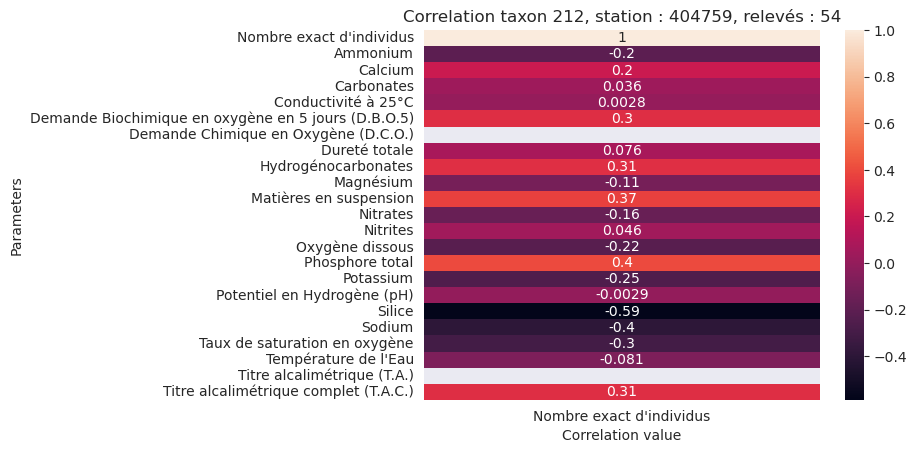

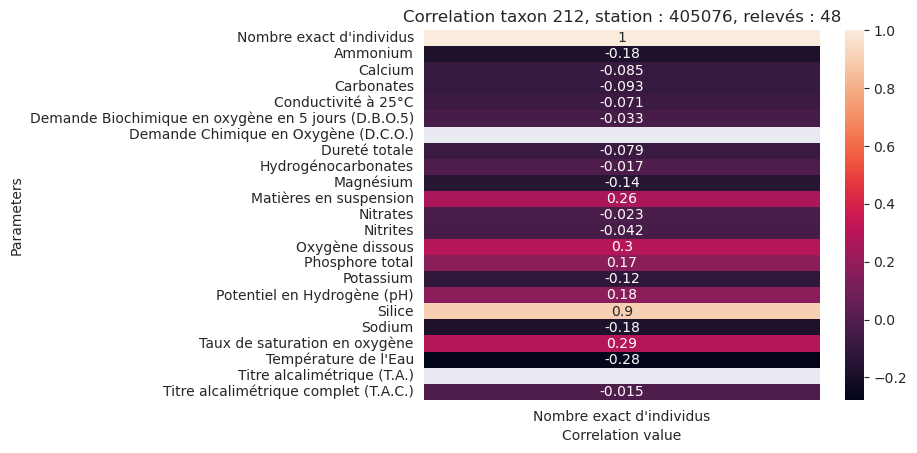

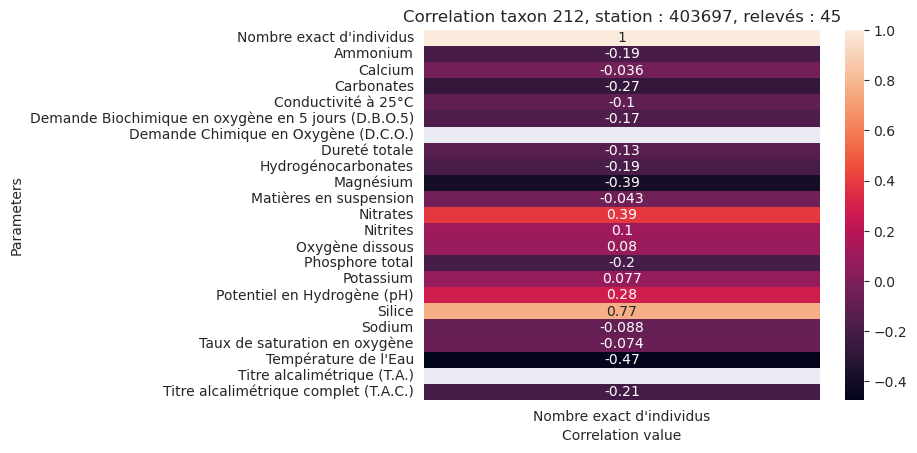

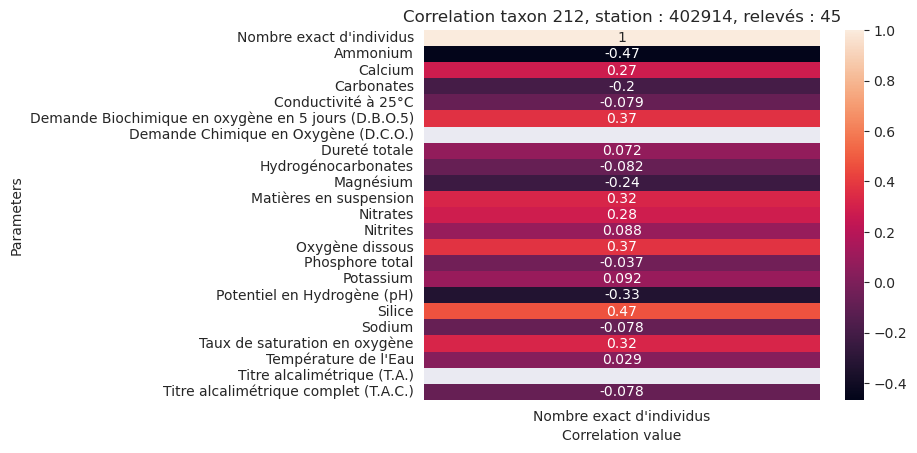

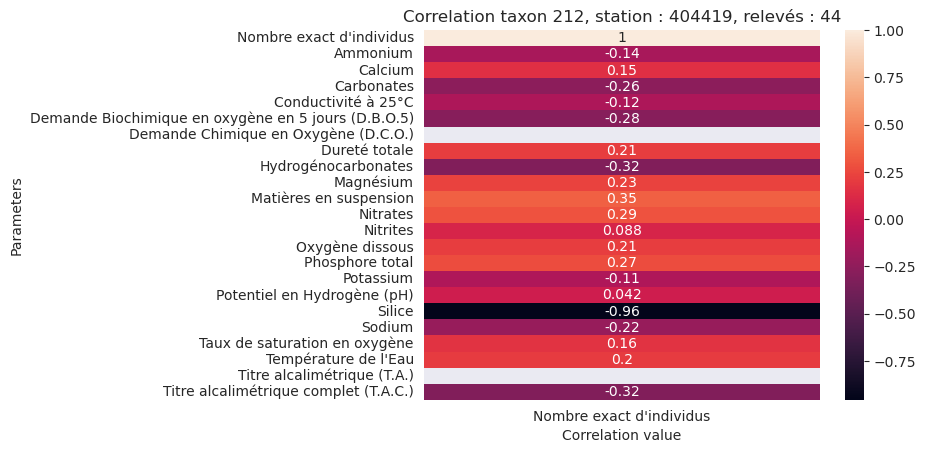

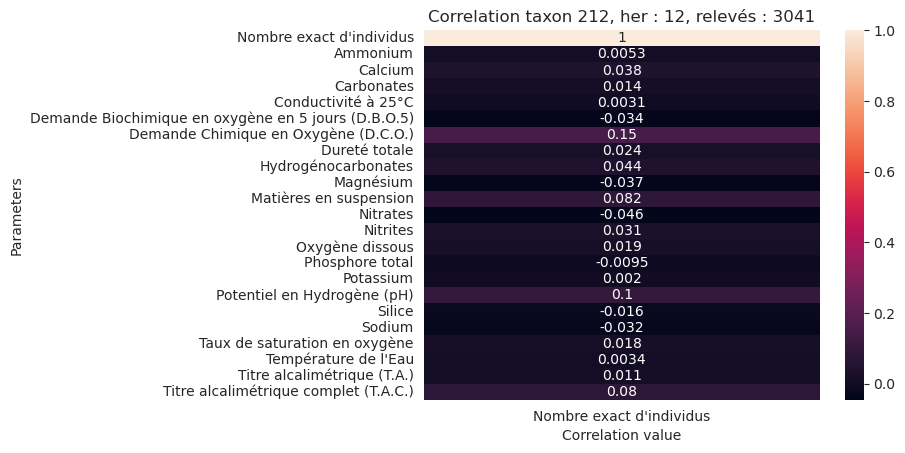

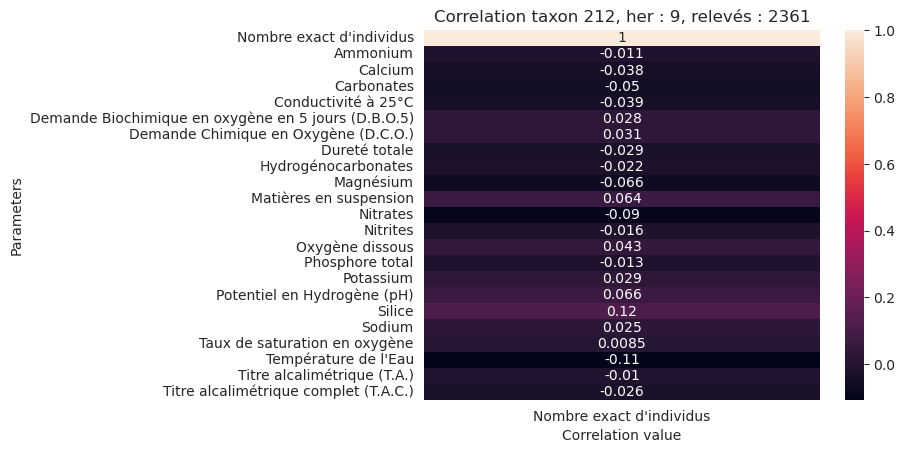

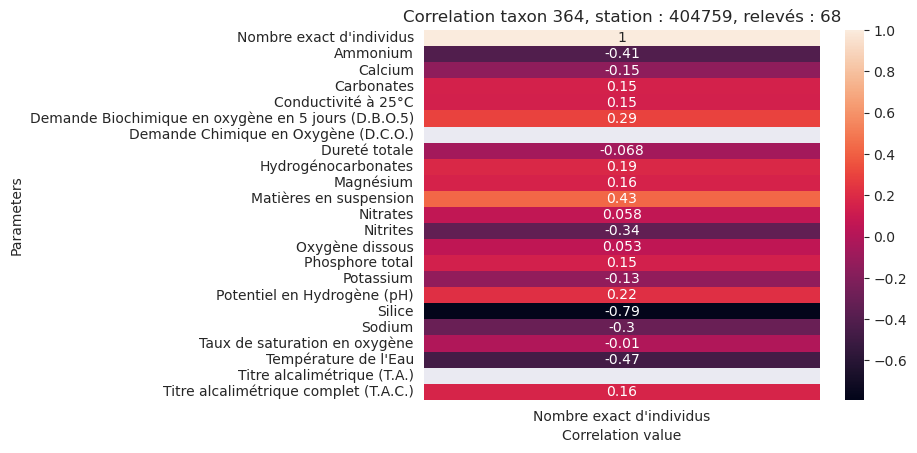

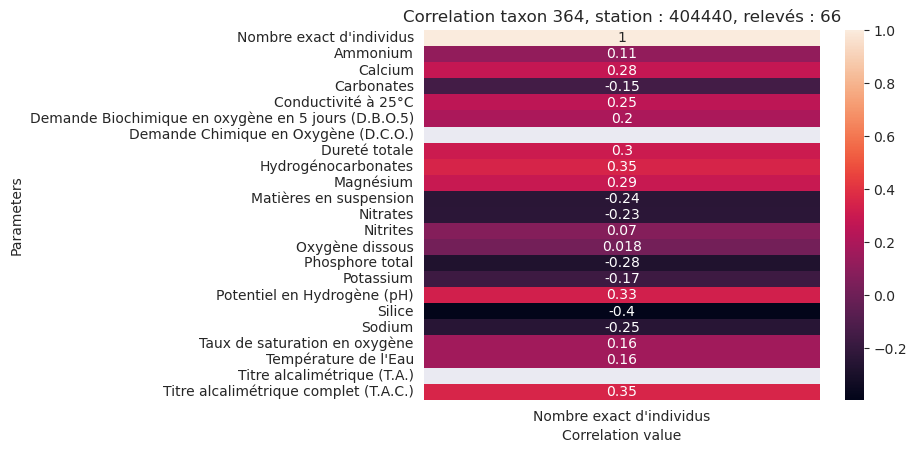

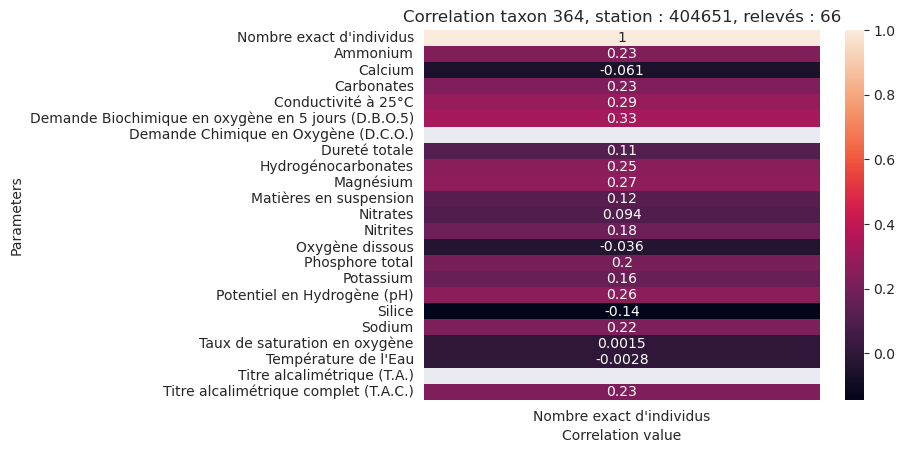

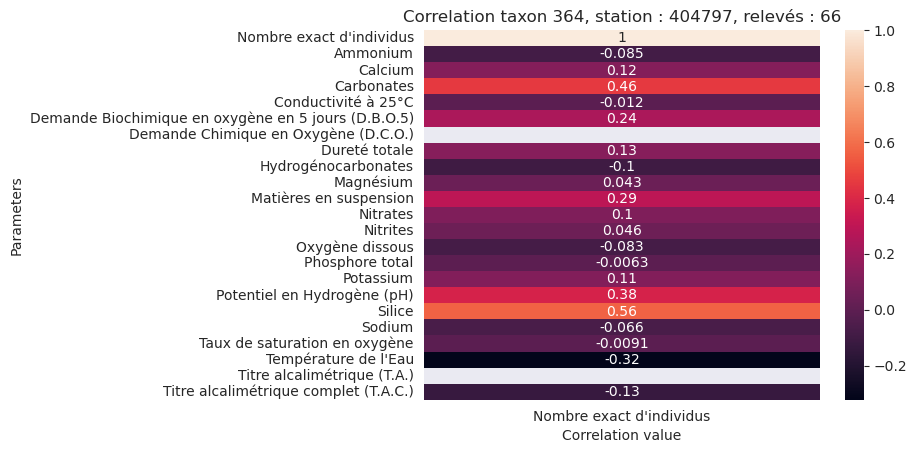

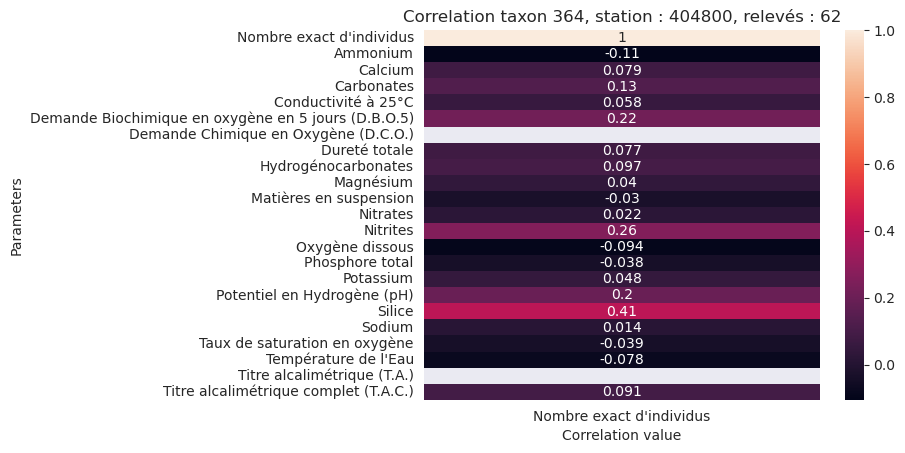

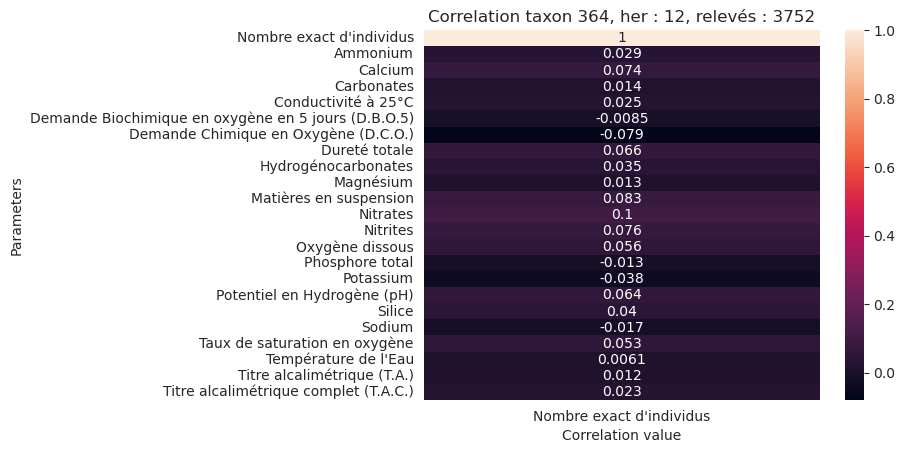

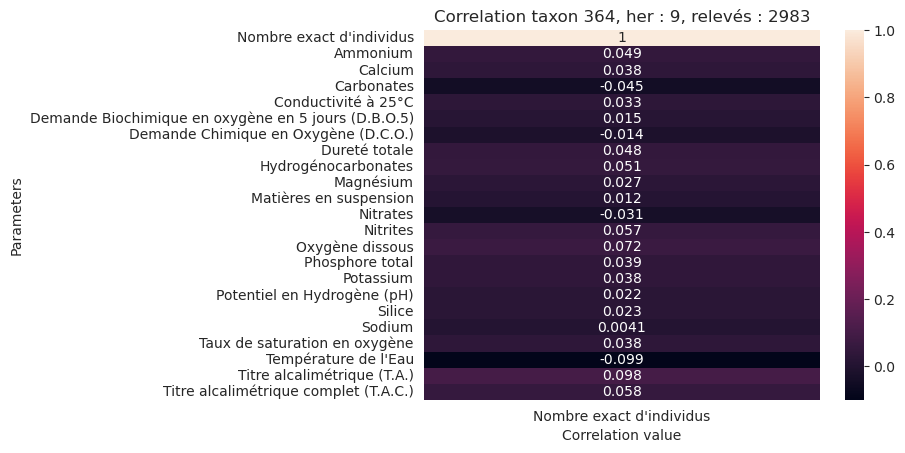

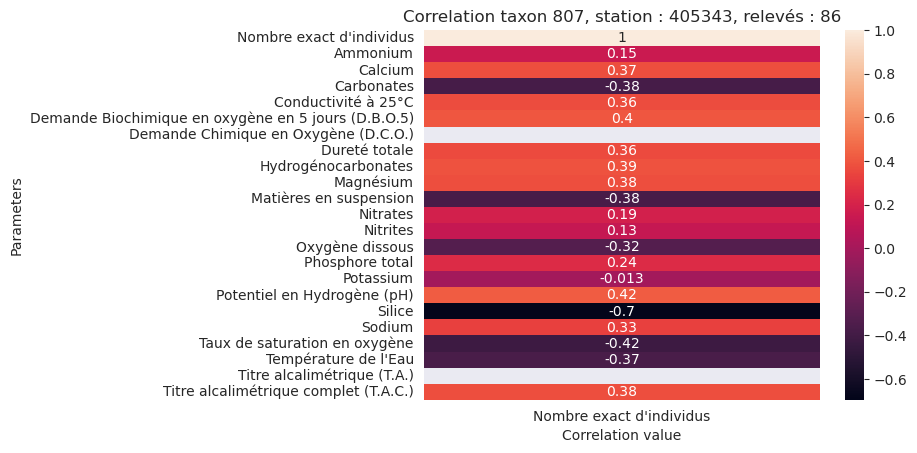

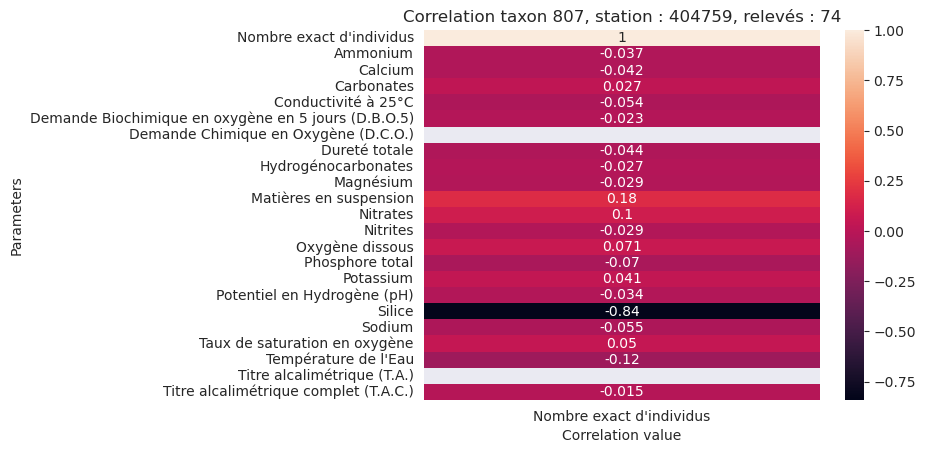

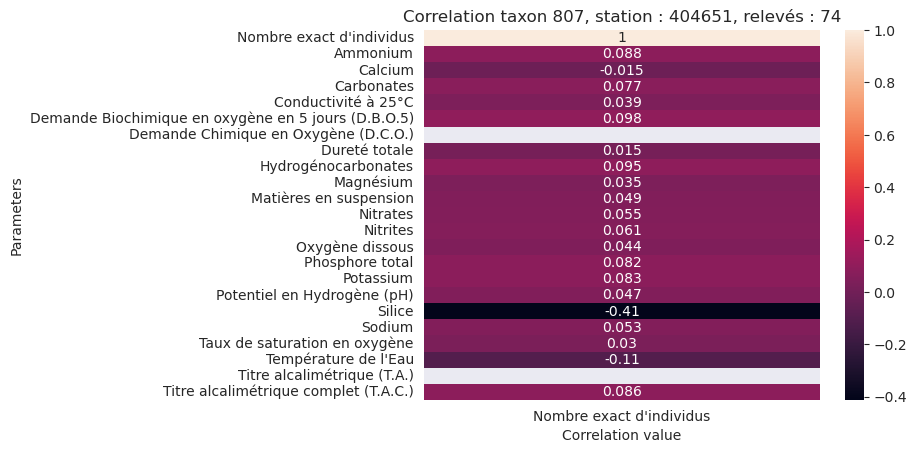

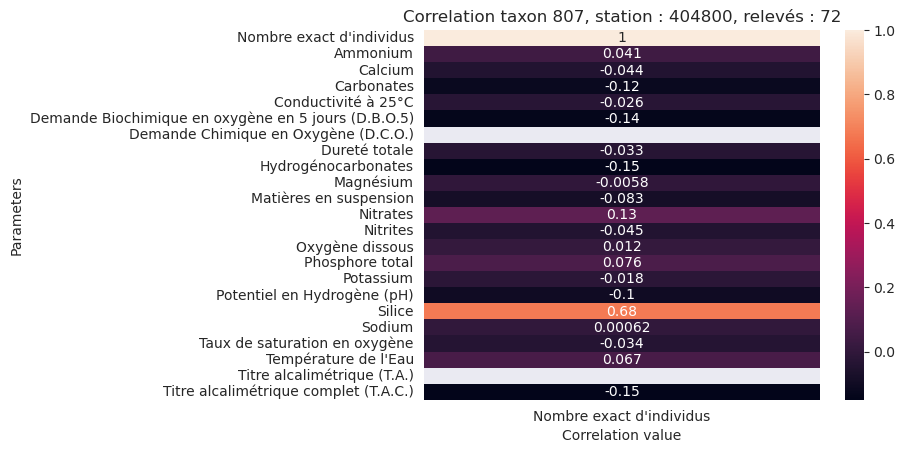

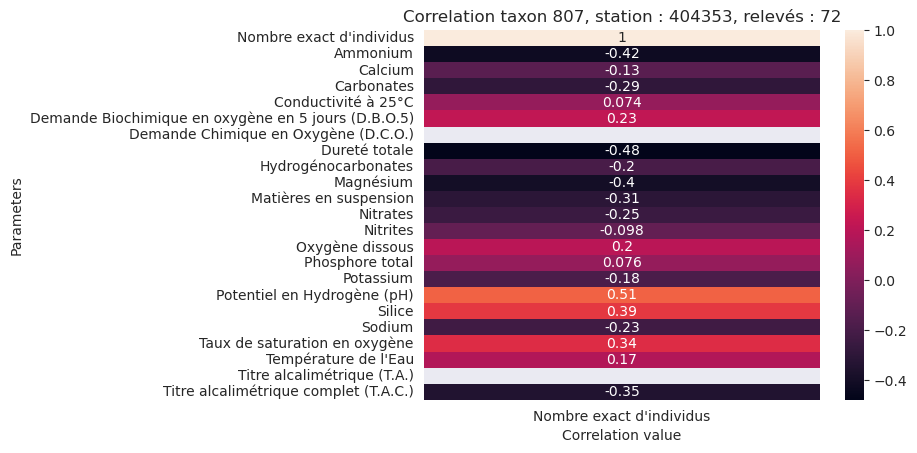

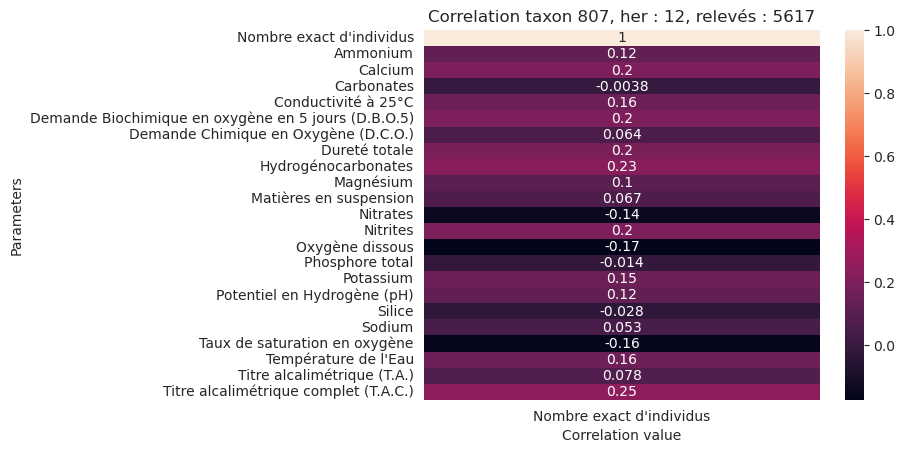

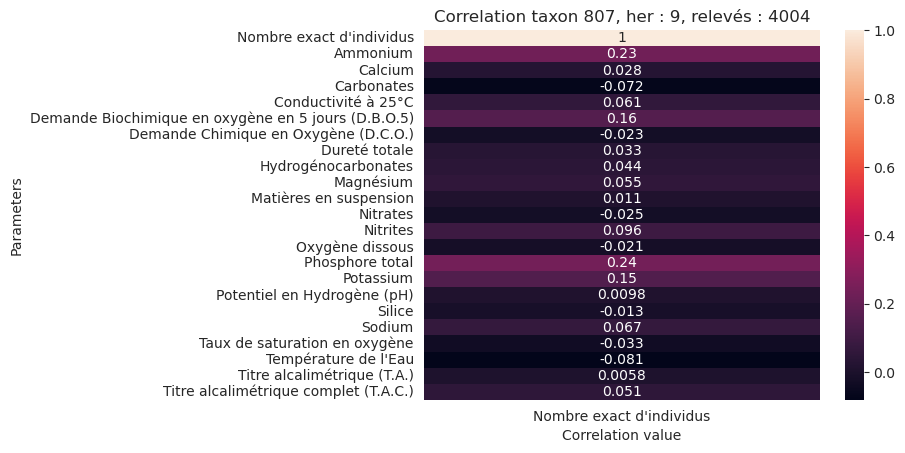

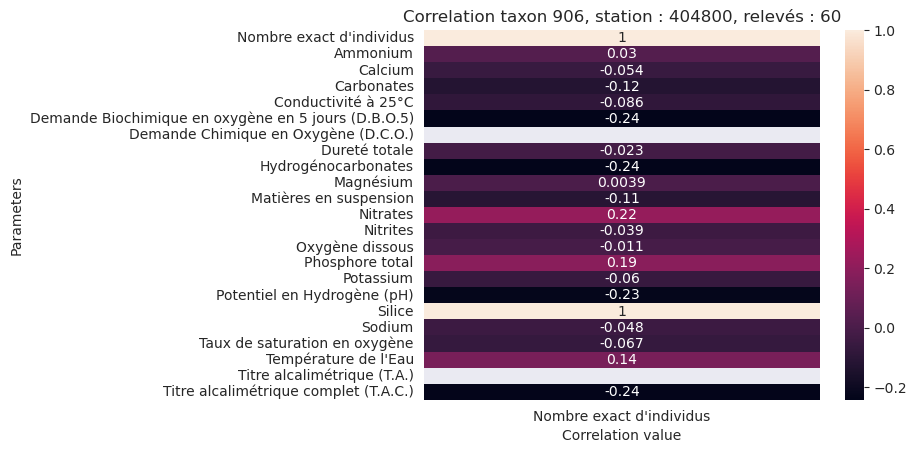

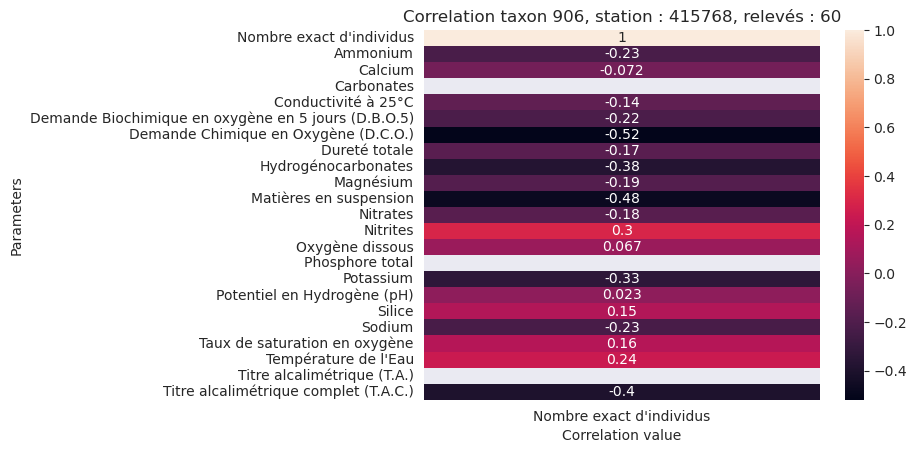

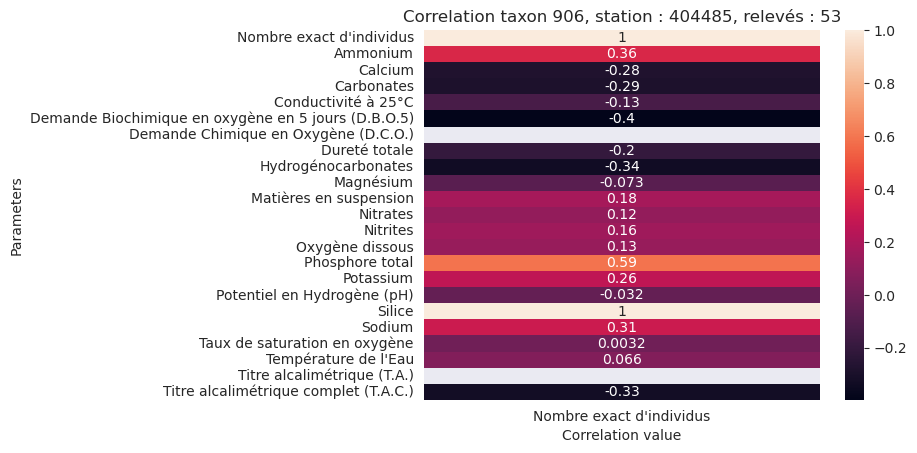

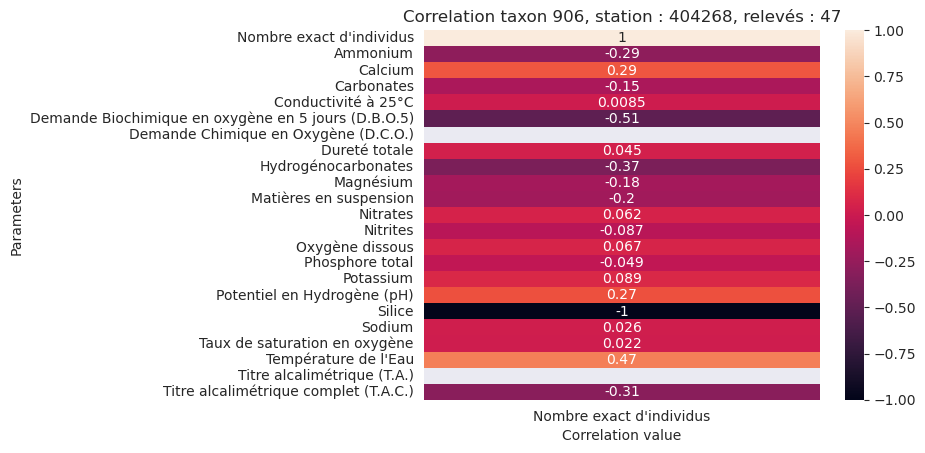

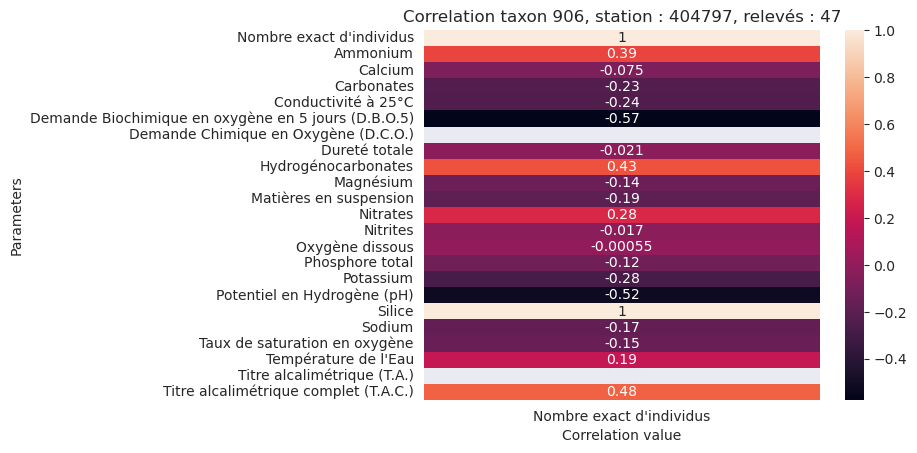

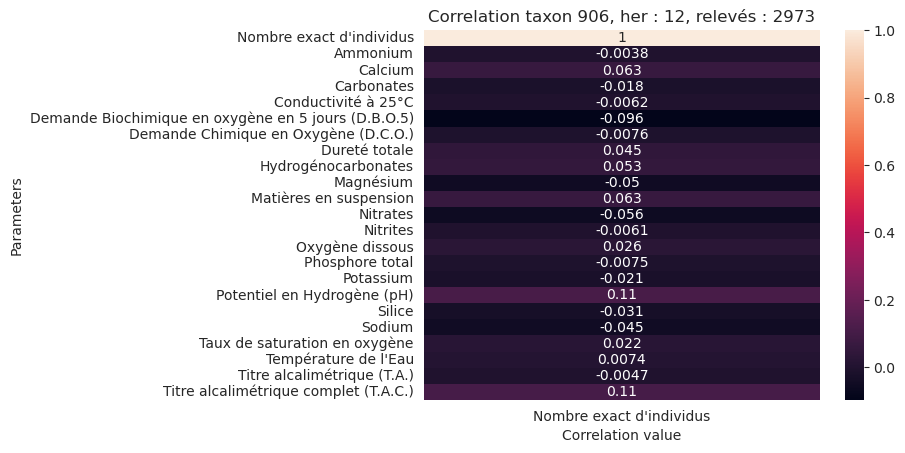

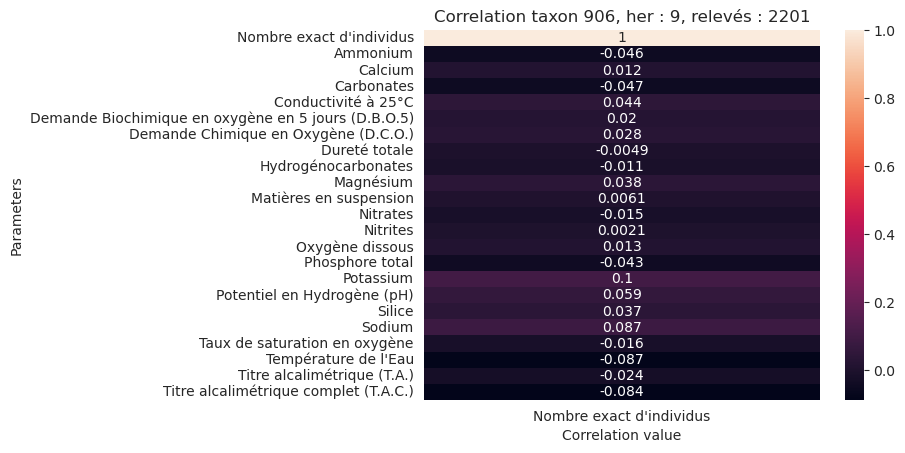

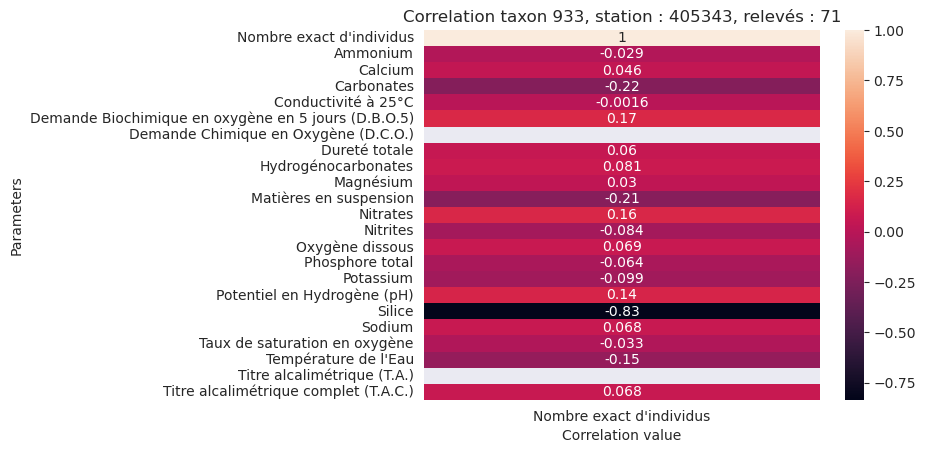

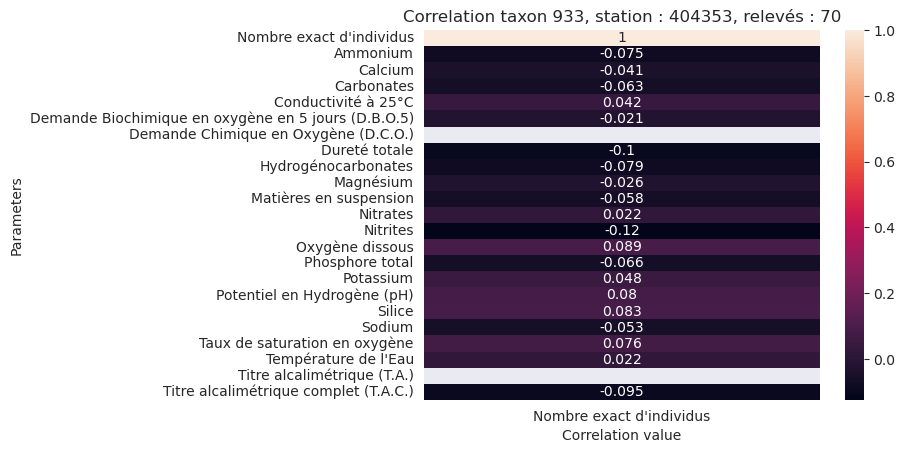

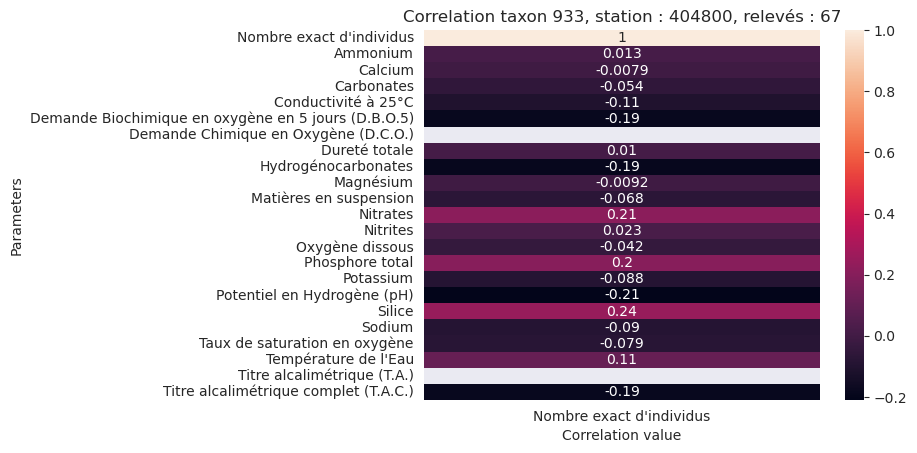

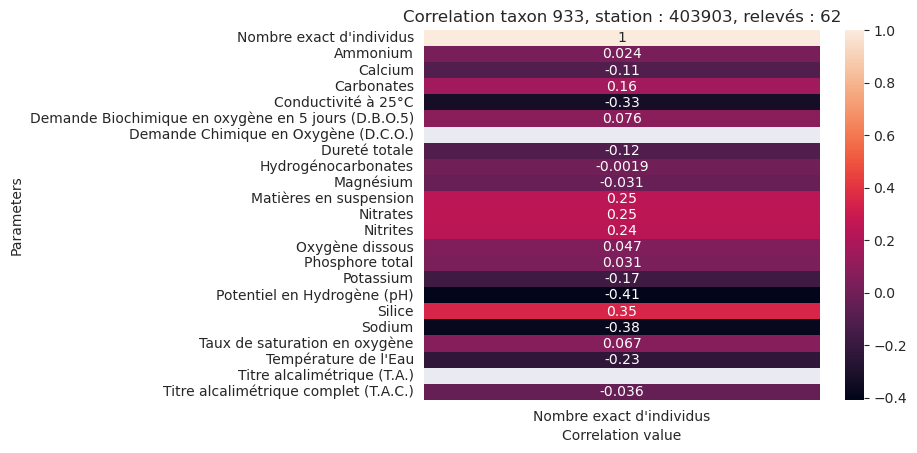

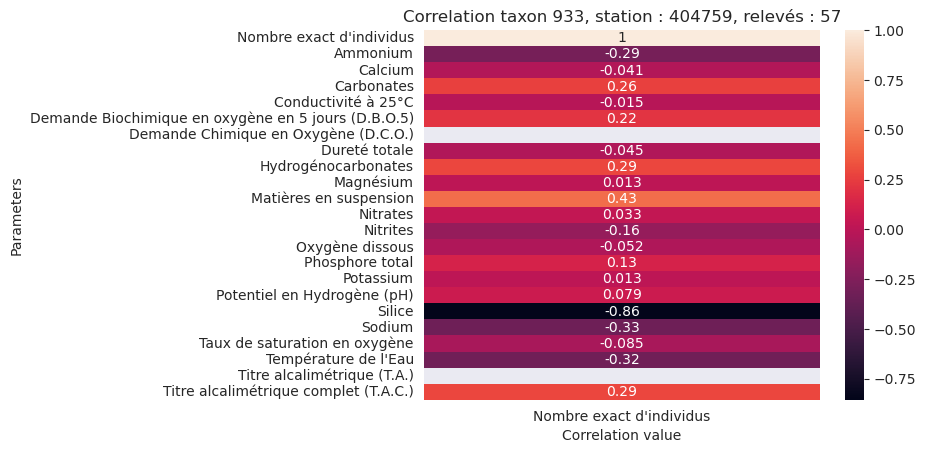

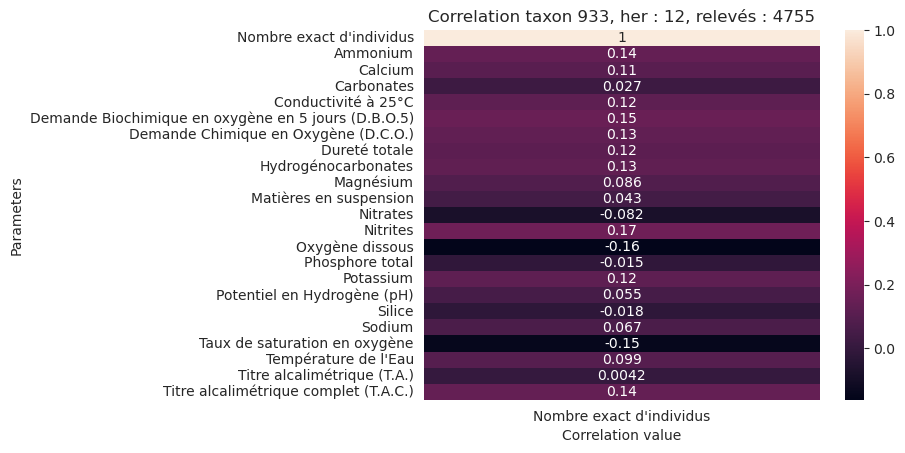

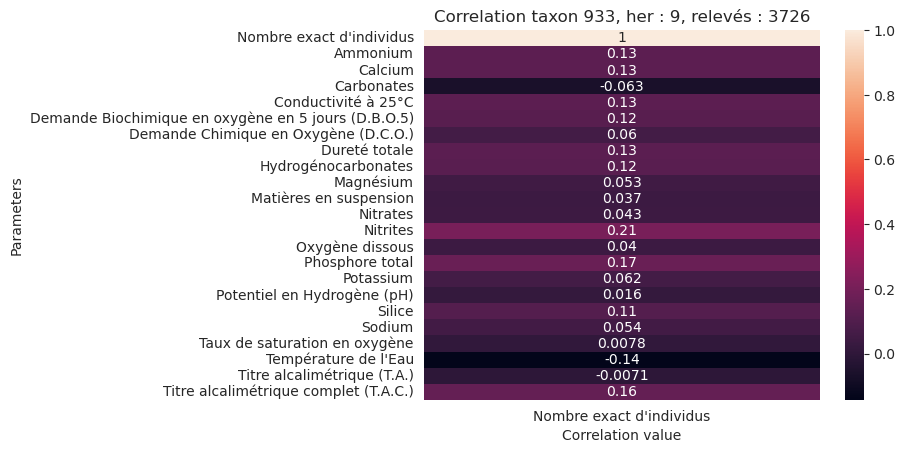

In [202]:
for taxon in taxons_to_keep:
    x_dict = compute_matrix_corr(taxon, station=5, her=2, plot=True)

On observe que de nombreux taxons sont corrélés avec le paramètre 1348, "Silice" sur certaines stations, on peut poser l'hypothèse que l'évolution de ce paramètre impacte ces taxons. De plus on observe également le taxon 933 est corrélé avec plusieurs paramètres sur certaines stations. Il pourrait être plus sensible que les autres taxons à des paramètres physico-chimiques

De manière plus générale, on observe que pour un même taxon, les corrélations varient grandement suivant la station. Ainsi, la corrélation sur tout les relevés d'un "her" montrent plutôt des valeurs de corrélation négligeable : même sur un taxon en particulier, l'équilibre optimal des paramètres varie suivant le lieu, ce qui laisse suggérer que les paramètres pris à l'unité ne suffisent pas à décrire les interactions de produisant.

On s'intéresse aussi à la moyenne des corrélations sur les k stations comportant le plus de relevés pour un taxon. On espère que cela permette de ressortir quelques paramètres qui influencent de manière plus visible un taxon.

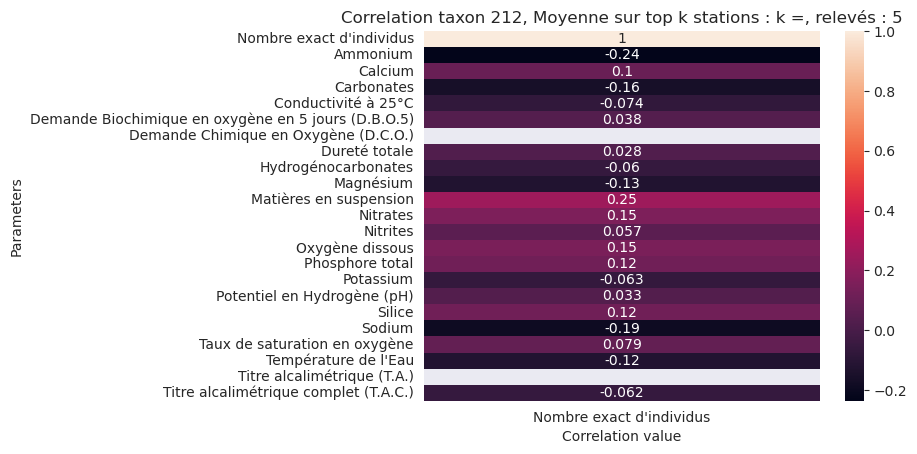

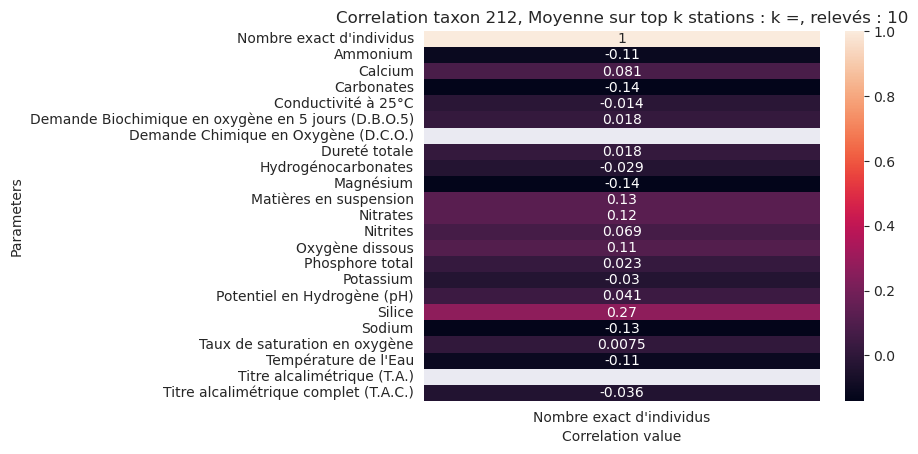

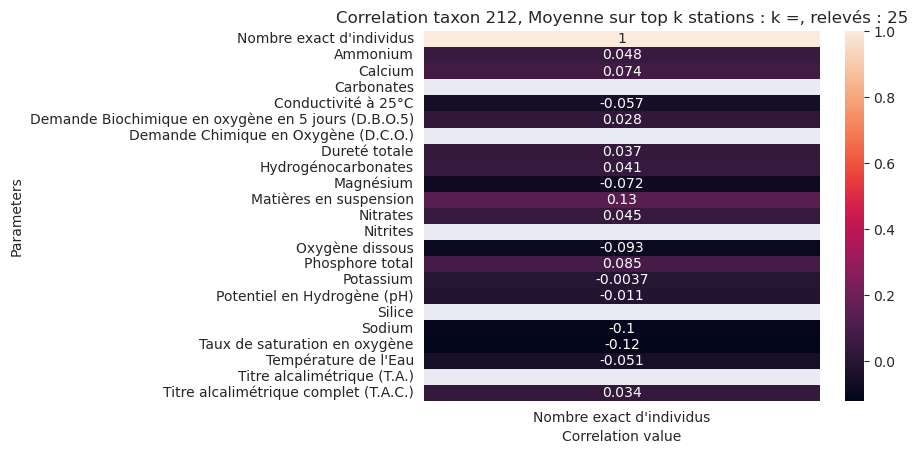

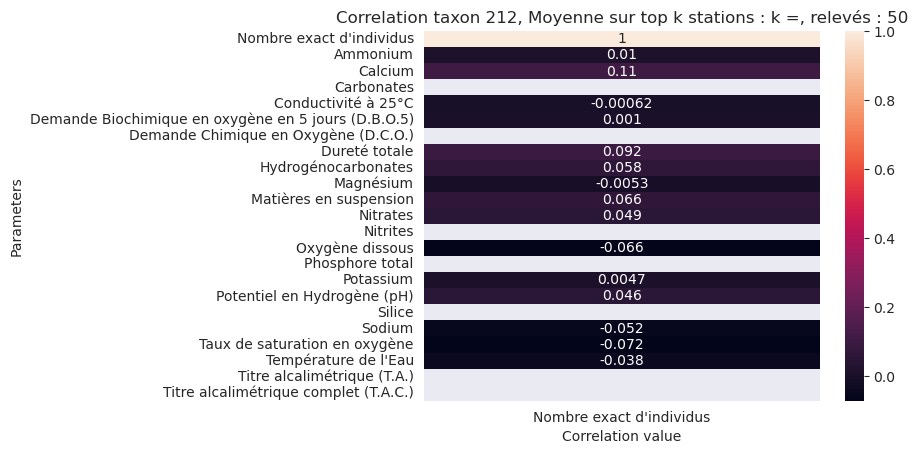

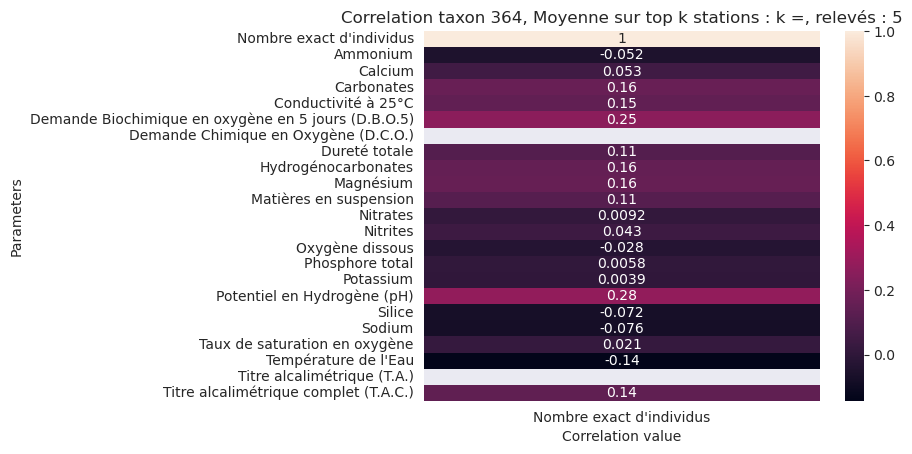

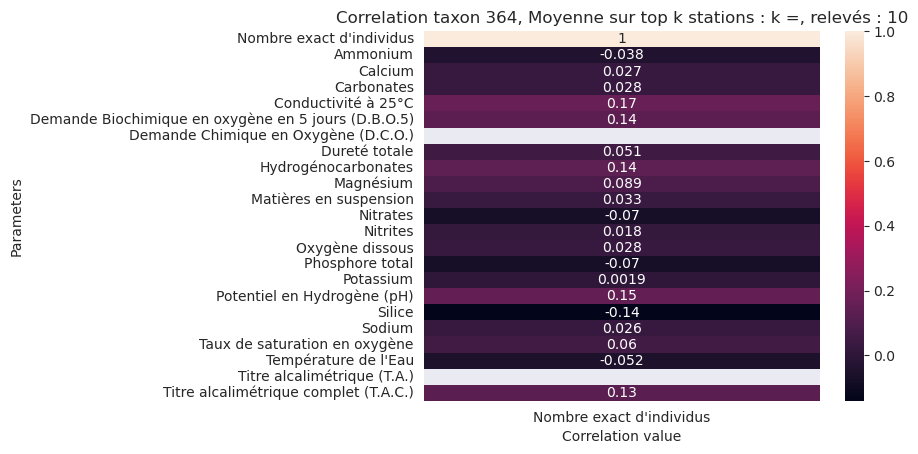

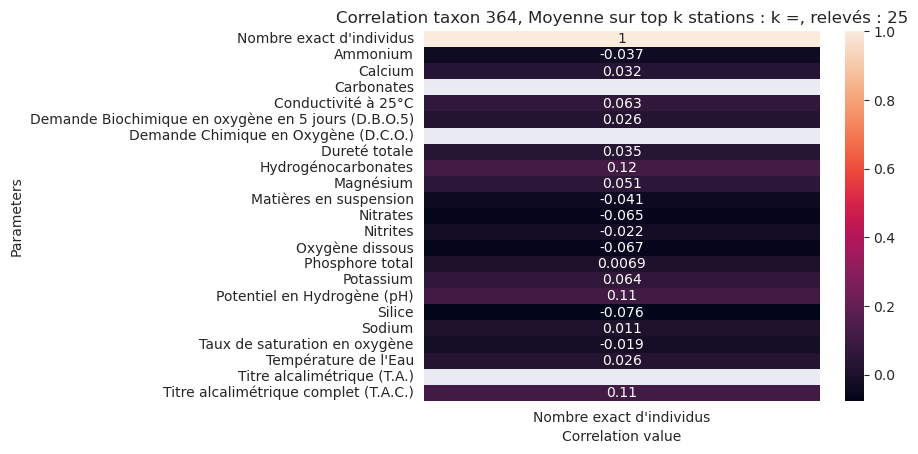

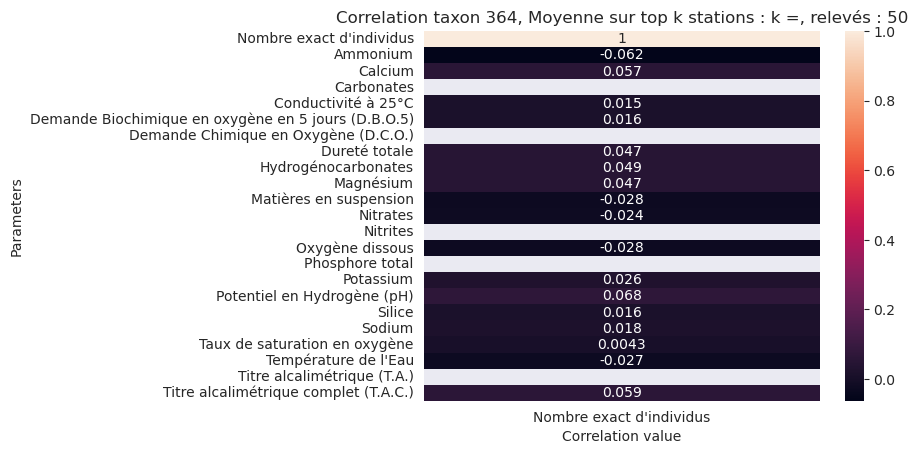

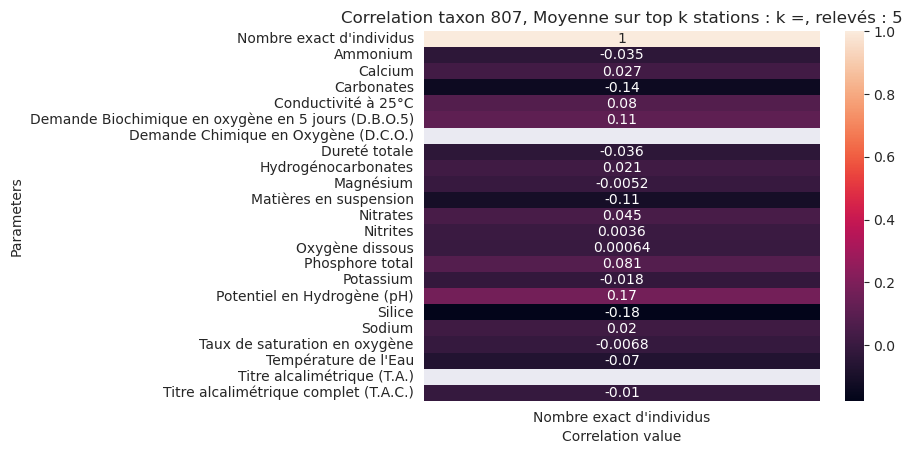

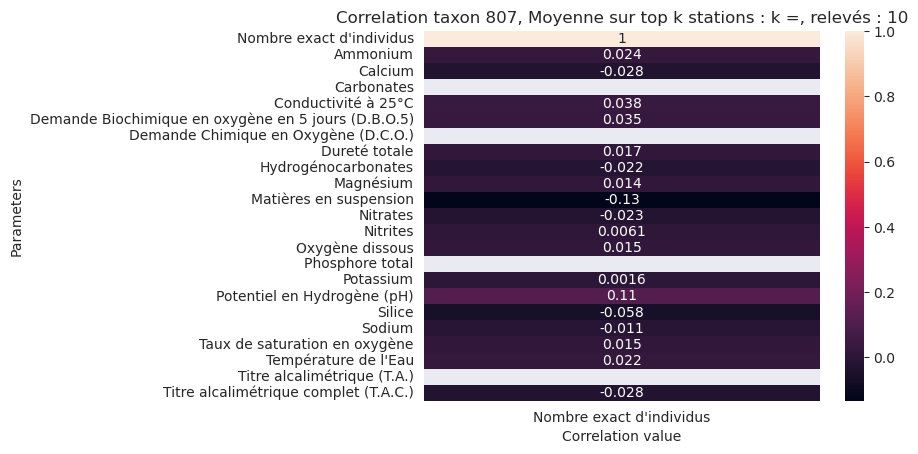

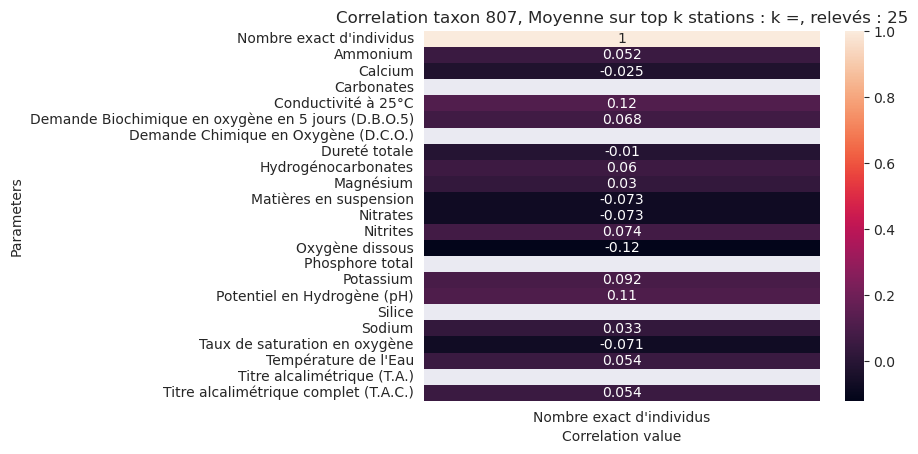

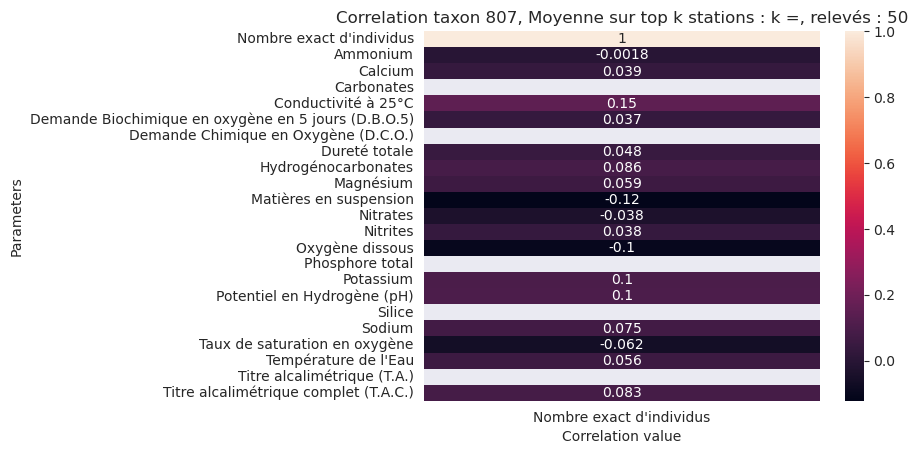

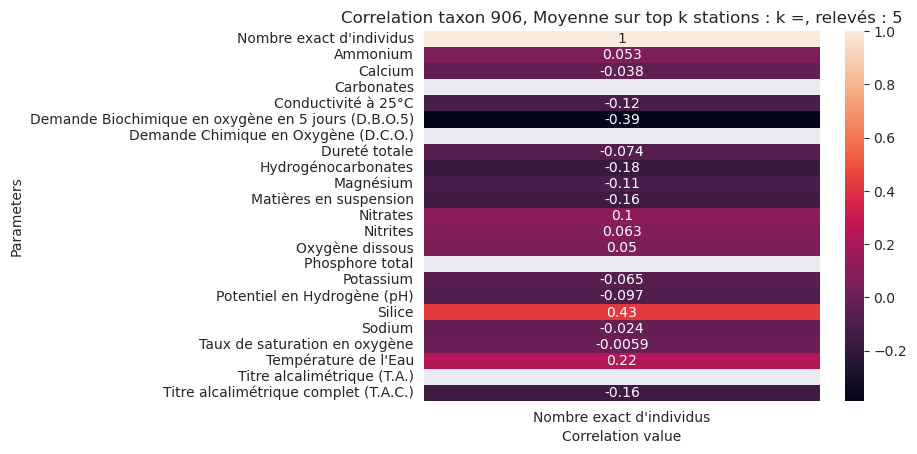

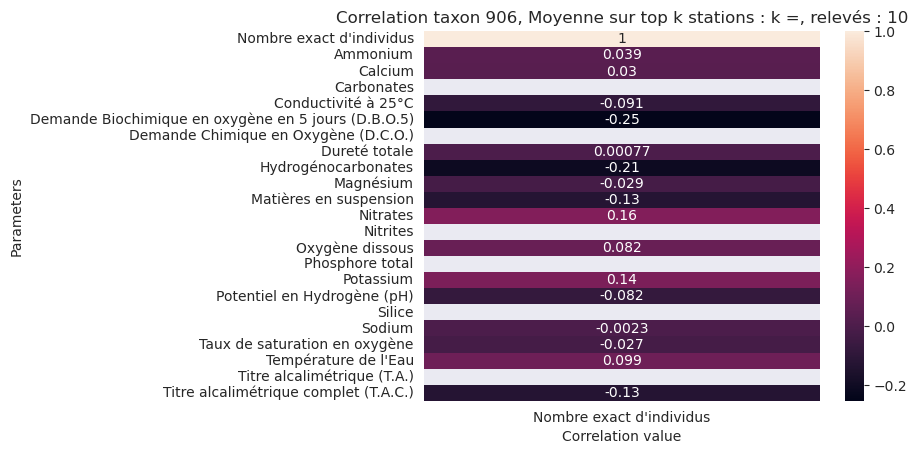

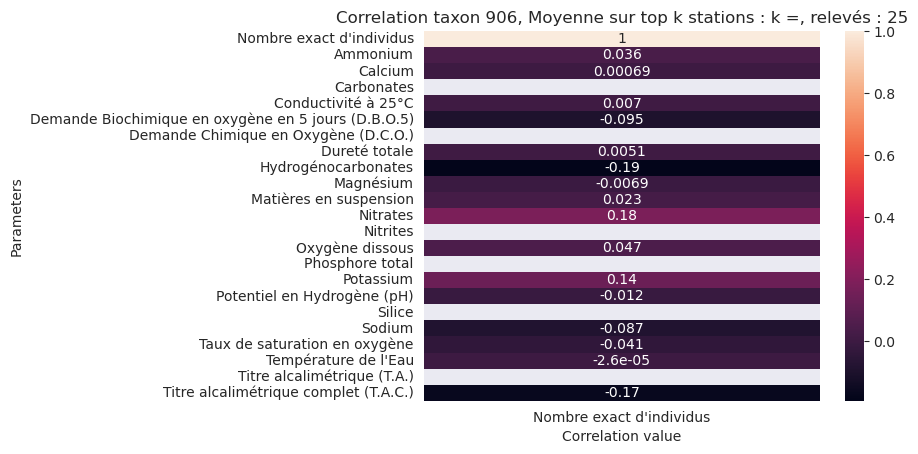

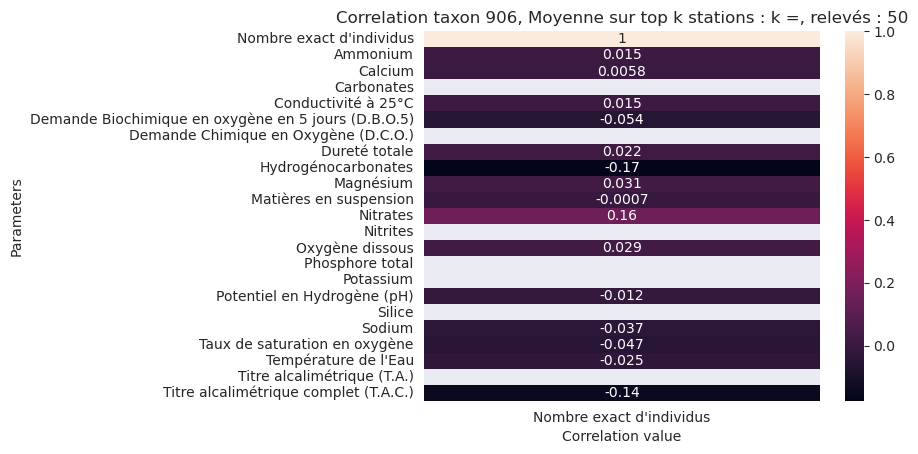

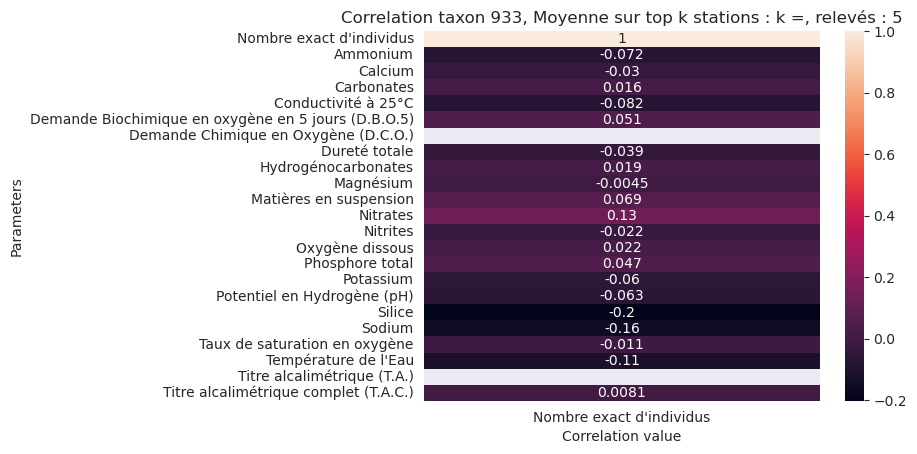

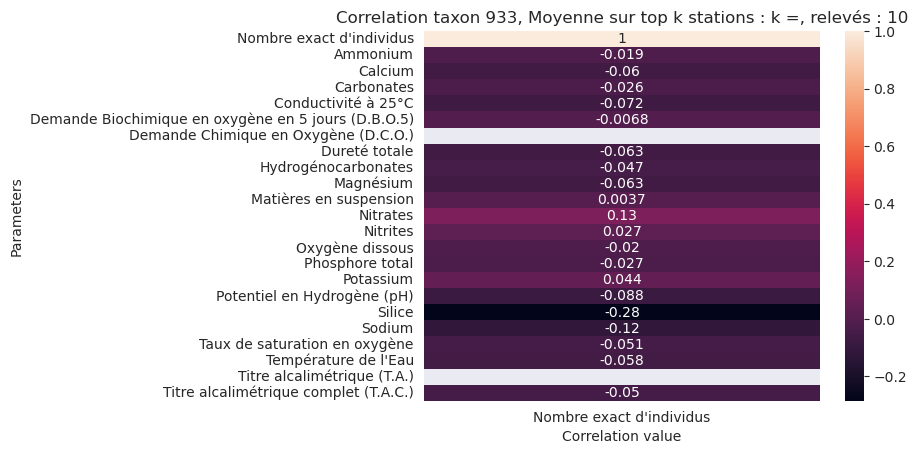

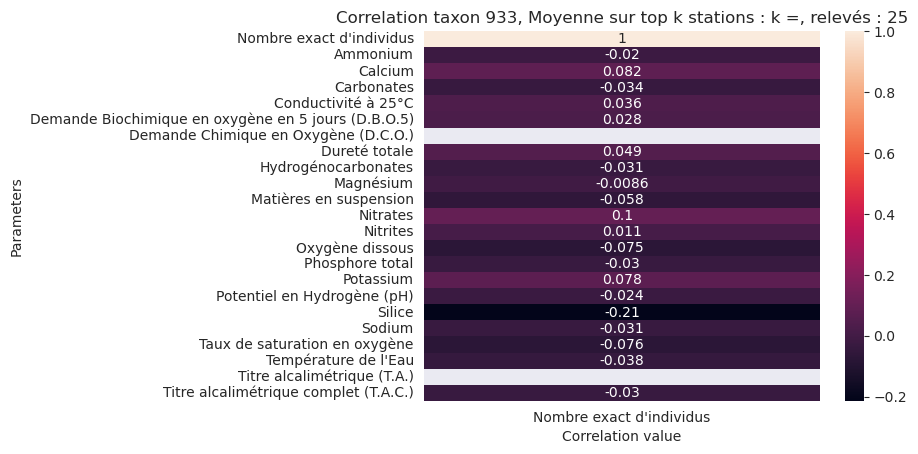

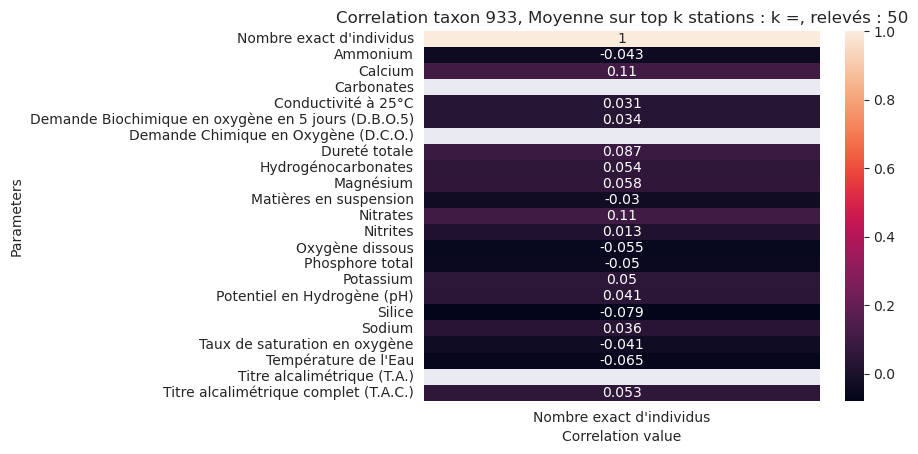

In [203]:
for taxon in taxons_to_keep:
    for k in [5, 10, 25, 50]:
        x_dict = compute_matrix_corr(taxon, station=k, her=2, plot=False)

        x = None
        for x_corr in x_dict["station"]:
            x = x_corr if x is None else x + x_corr
        x = x.divide(len(x_dict["station"]))
        plot_x(x, mode="Moyenne sur top k stations", id="k =", num_releves=f"{len(x_dict['station'])}", taxon=taxon)

Quand on prend un nombre "raisonnable" de stations pour la moyenne, on tend à ne pas avoir de corrélation directe.
Les cases NA tendent aussi à poser un problème.

La prochaine étape de l'analyse pourrait constituer en l'étude de combinaisons linéaires de 2 ou 3 paramètres et leur corrélation avec le nombre d'individus.
Plus généralement, nous avons ignoré le Dataframe contenant des séquences d'altérations de l'eau et leur label. Nous en avons compris que ce tableau recensait des combinaisons, ou conditions sur un ensemble de paramètres menant à une altération notable de l'eau, labellisées par impact.

Ainsi, on pourrait, avant de construire la matrice d'altération, filtrer les lignes en ne conservant que celle qui présente au moins une séquence d'altération importante. On garderait alors des lignes dans lesquels on sait que les paramètres ont un impact direct sur le milieu dans lequel évolue le taxon étudié. Il serait peut-être possible d'extraire des corrélations pertinentes.

Pour ce faire, une approche que nous pensons possible, mais que nous n'avons pas eu le temps d'essayer :
- Construire un dictionnaire imbriqué, dont les clés du premier sont les couples station/année (ou l'index de la ligne) et les clés intérieures sont les différents paramètres
- Dans le dictionnaire associé à chaque paramètre, on stocke les séquences d'altérations compatibles avec la valeur du paramètre.
- Pour chaque séquence, on teste si elle est présente dans le dictionnaire associé à chaque paramètre impliqué dans celle-ci
- Si oui, on peut l'ajouter à une liste associée au couple station/année permettant de garder en mémoire les séquences d'altérations présentes sur chaque ligne.
- Sinon, on supprime cette séquence de tout les dictionnaires dans lesquels elle se trouve
- Enfin, on supprime une ligne si les dictionnaires de chaque paramètre sont vides

# Analyses comparées d'évolutions de population de taxon et de paramètres physico-chimiques

On cherche maintenant à étudier l'évolution de la population d'un taxon sur une station, en analysant l'évolution sur la même période de certains paramètres.

In [204]:
ph_test = physicochimie_df[physicochimie_df['stn_id'].isin(stn_taxon['id'])]

In [205]:
def plot_graph(taxon_faune_nbr, ph_test, station_test, taxon_test, p):
    
    df_station_test = taxon_faune_nbr[taxon_faune_nbr['id'] == station_test]
    
    fig, ax = plt.subplots(figsize = (12,6))
    sns.lineplot(data=df_station_test[(df_station_test['taxon_id'] == taxon_test)], x="date_year", y="Nombre exact d'individus",
                 hue="taxon_id", errorbar=None, ax=ax, palette="tab10")
    fig.autofmt_xdate()
    plt.title('{} evolution on station {}'.format(taxon_test, station_test))
    plt.show()
    ph_test_stn = ph_test[ph_test['stn_id'] == station_test]
    fig, ax = plt.subplots(figsize = (12,6))
    sns.lineplot(data=ph_test_stn[(ph_test_stn['parameter'] == p)], x="date_year", y="valeur", hue='parameter_name', errorbar=None, ax=ax, palette="tab10")
    fig.autofmt_xdate()
    plt.title('{} evolution on station {}'.format(p, station_test))
    plt.show()

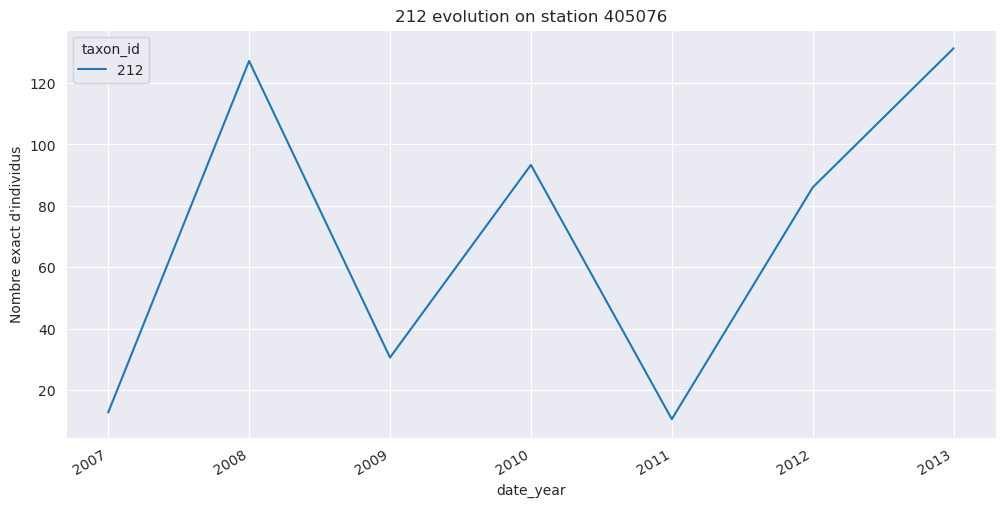

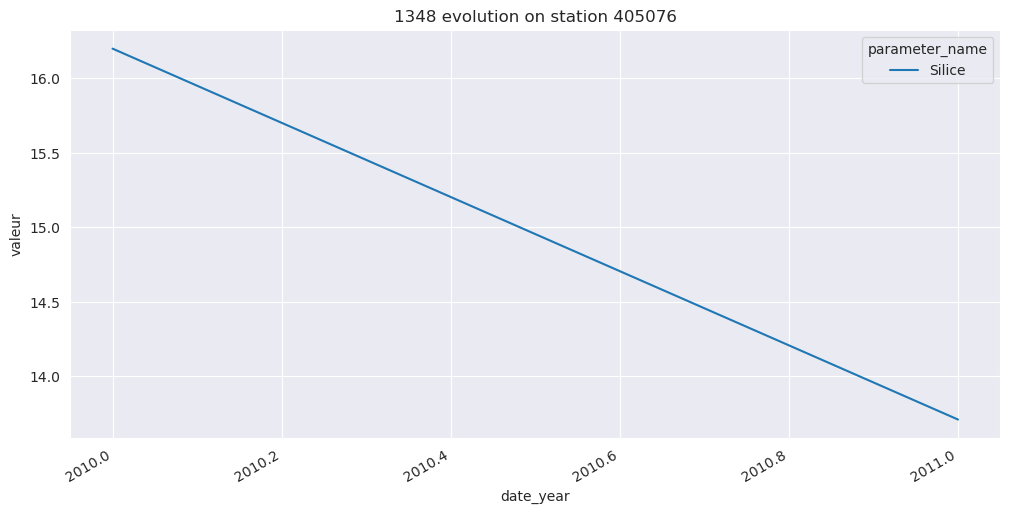

In [206]:
station_test = 405076
taxon_test = 212
p = 1348


plot_graph(stn_taxon, ph_test, station_test, taxon_test, p)

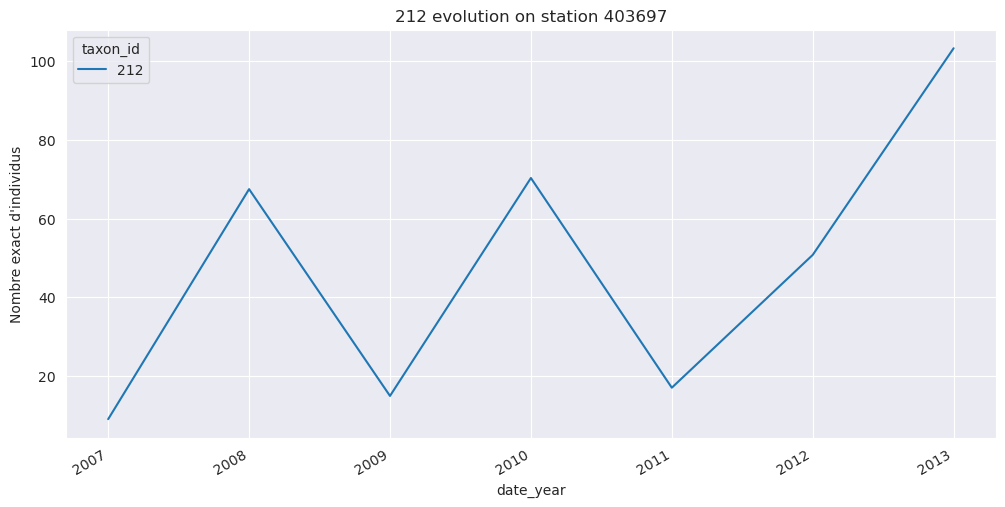

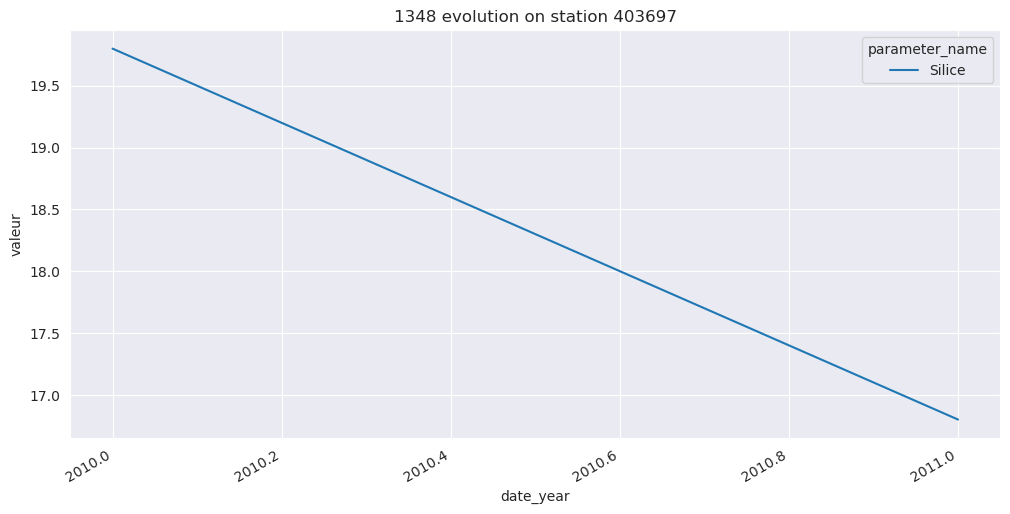

In [207]:
station_test = 403697
taxon_test = 212
p = 1348


plot_graph(stn_taxon, ph_test, station_test, taxon_test, p)

La corrélation observée sur la silice sur les taxons étudiés est en fait dû au manque de mesure et n'est donc pas exploitable.

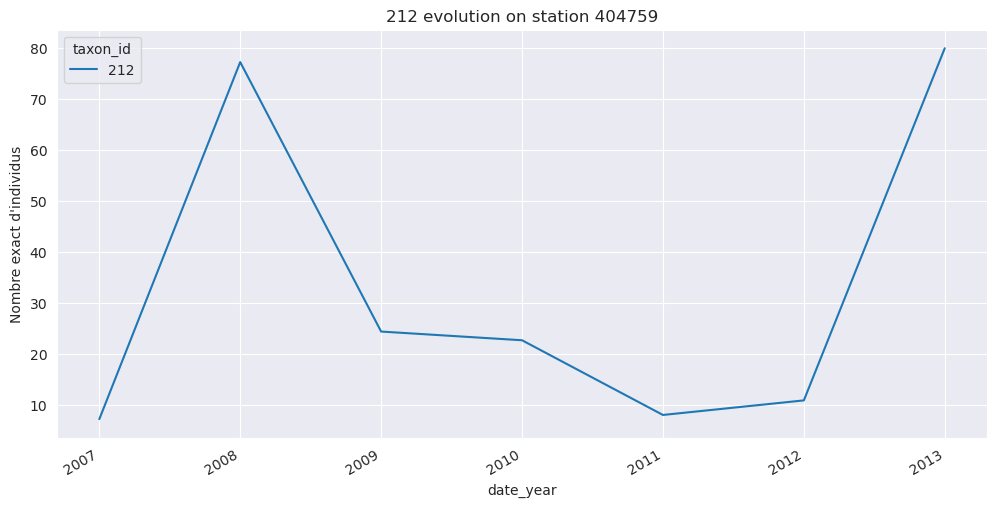

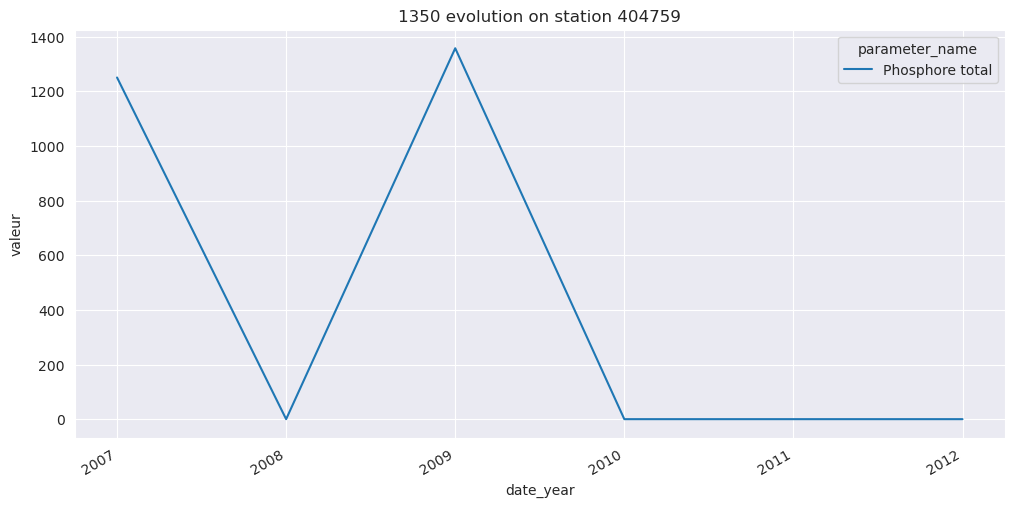

In [208]:
station_test = 404759
taxon_test = 212
p = 1350


plot_graph(stn_taxon, ph_test, station_test, taxon_test, p)

On observe que le nombre d'individus tombe fortement lors des pics de présence de phosphore, on pourrait donc poser l'hypothèse que le taxon 212 est sensible à la forte présence de phosphore. On observe également que la population prend du temps à revenir même lorsque le phosphore est dissipé.

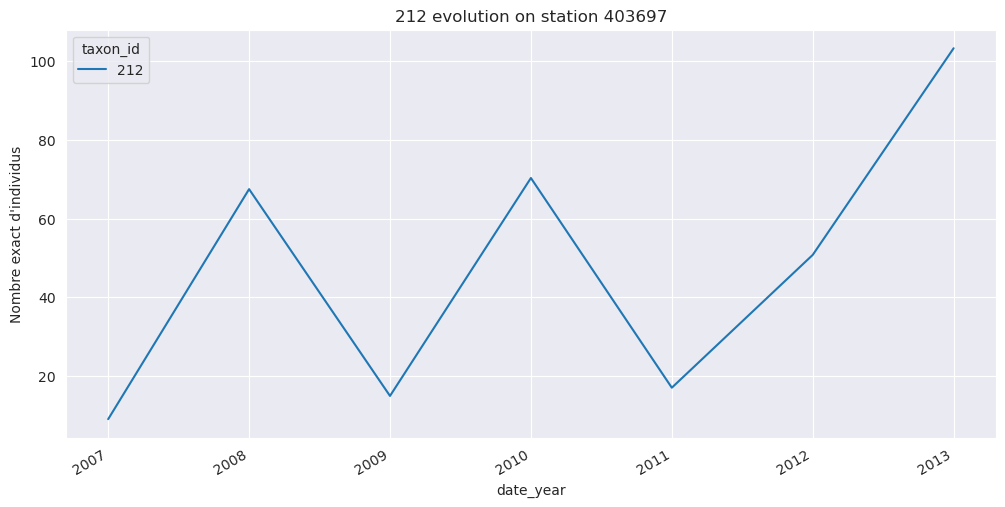

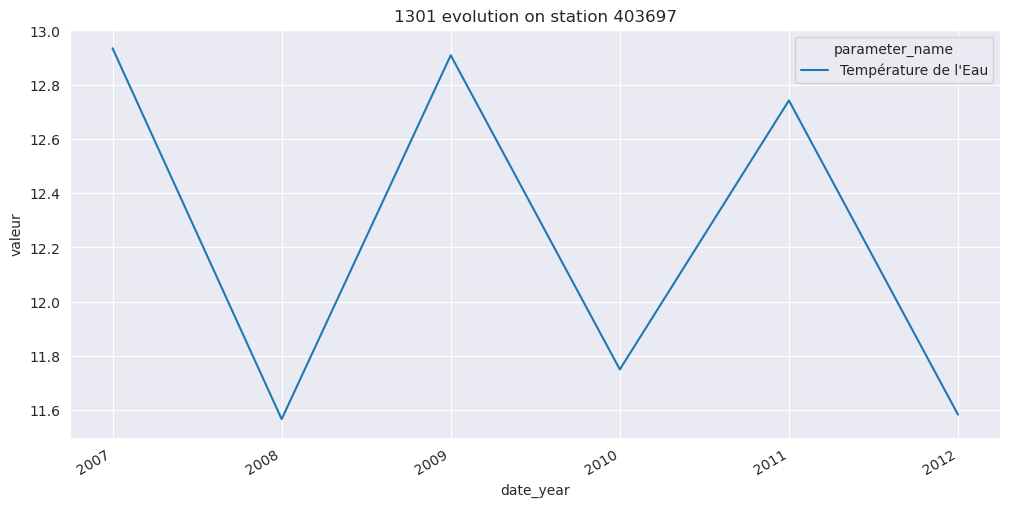

In [209]:
station_test = 403697
taxon_test = 212
p = 1301


plot_graph(stn_taxon, ph_test, station_test, taxon_test, p)

Ce taxon semble également sensible aux variations de température, lorsque la température est trop haute la population est moindre

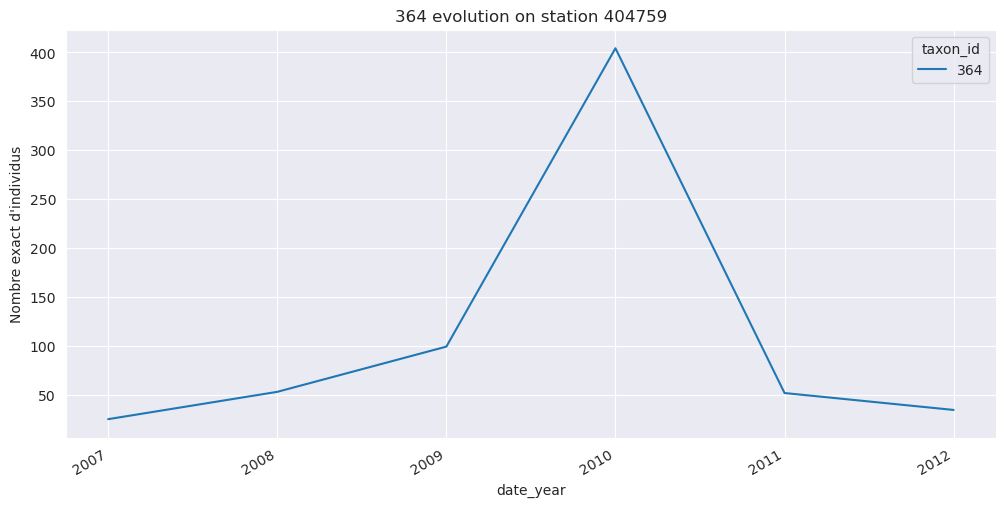

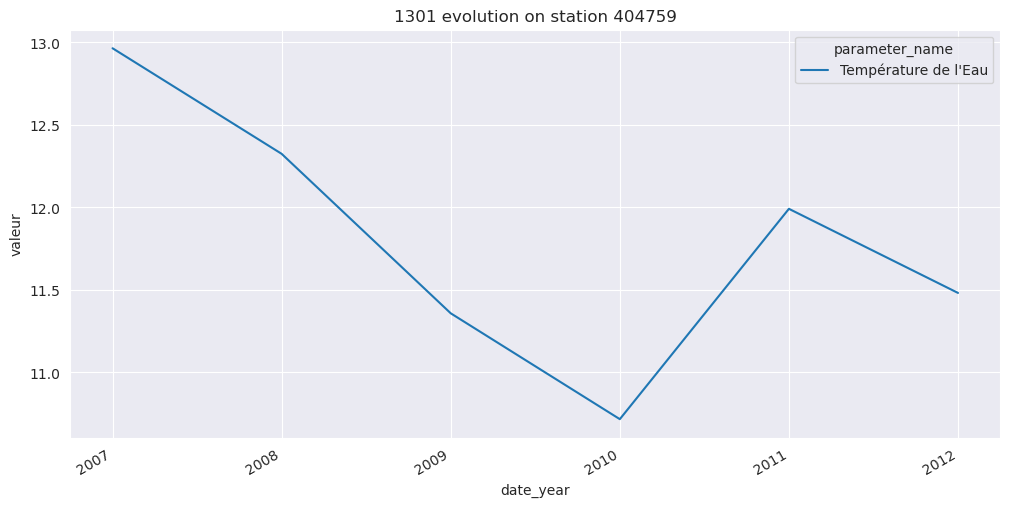

In [210]:
station_test = 404759
taxon_test = 364
p = 1301


plot_graph(stn_taxon, ph_test, station_test, taxon_test, p)

Le taxon 364 semble également sensible aux variations de température, lorsque la température est trop haute la population est moindre. On voit sur le graphique ci-dessus que lorsque la température est à son plus bas (2010) la population est le plus élevé.

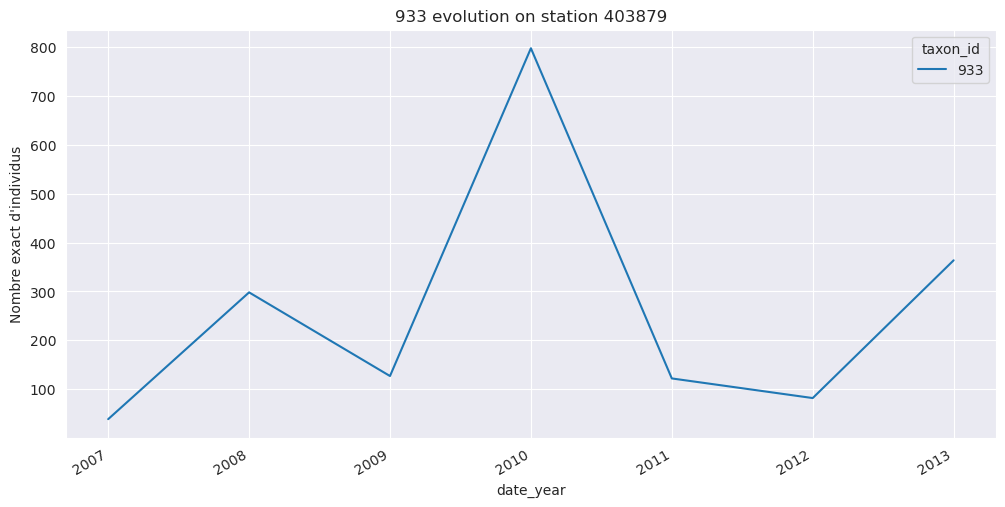

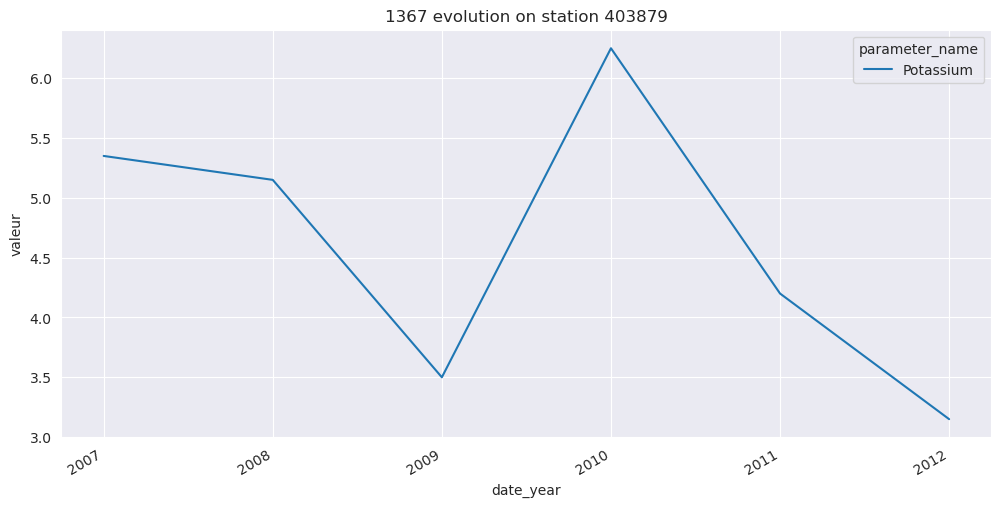

In [211]:
station_test = 403879
taxon_test = 933
p = 1367


plot_graph(stn_taxon, ph_test, station_test, taxon_test, p)

Pour le taxon 933 on peut trouver un lien avec le potassium. Il semble avoir besoin de celui-ci pour pouvoir peupler un environnement.

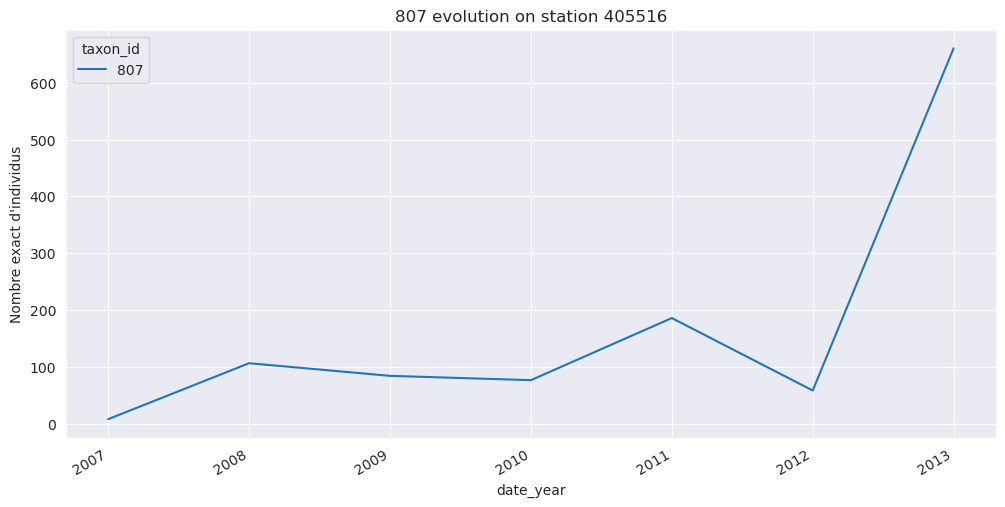

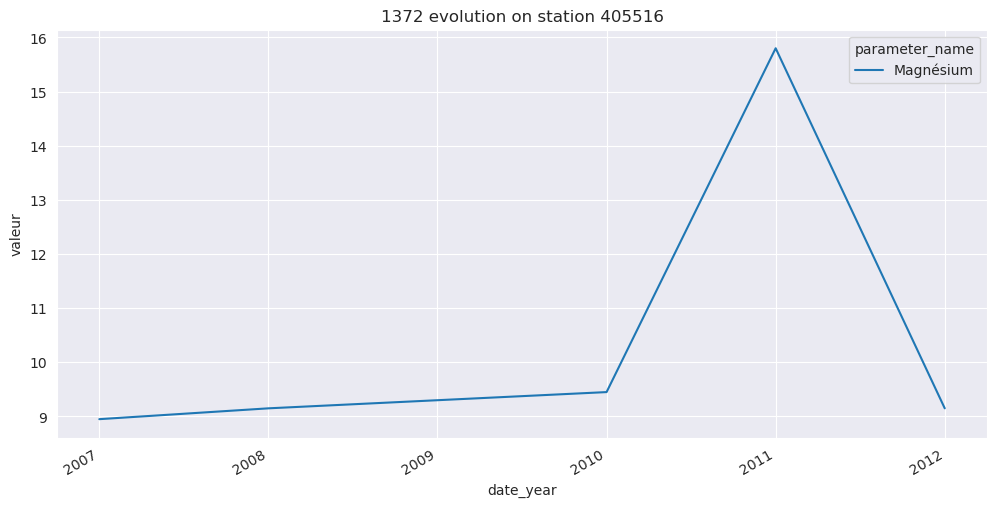

In [212]:
station_test = 405516
taxon_test = 807
p = 1372


plot_graph(stn_taxon, ph_test, station_test, taxon_test, p)

Le taxon étudié ici est le 807 (Chironomidae). Comme mentionné plus haut, après une pollution organique majeure ou durable, les Chironomidae font partie des espèces pionnières qui contribuent à la résilience de l'écosystème. Le pic d'augmentation de la population de cette espèce à partir de 2012 pourrait signifier la disparition d'une pollution notable de l'environnement à partir de cette année. Cela pourrait laisser penser que le magnésium est un bon indicateur de la viabilité d'un habitat, le pic suivant celui de la quantité de magnésium lors de 2011.

Nous pouvons voir que s'il est difficile d'extraire des relations simples de corrélations entre paramètres uniques et nombre d'individus, cette quantité semble corréler dans plusieurs exemples précis avec l'évolution ou le comportement de différents paramètres physico-chimique. Ceci est un élément de plus laissant penser qu'il serait pertinent de poursuivre l'analyse en s'intéressant à des combinaisons de paramètres ou à des séquences d'altérations.